# 03. Modeling - Advanced Version
## Spaceship Titanic - Kaggle Competition

이 노트북에서는 다양한 모델과 Optuna 하이퍼파라미터 튜닝, 고급 앙상블 기법을 활용합니다.

### 포함된 개선 사항
1. **Optuna 하이퍼파라미터 튜닝**: LightGBM, XGBoost, CatBoost 최적화
2. **추가 모델**: RandomForest, ExtraTrees, HistGradientBoosting
3. **다양한 앙상블**: Optuna 가중치 최적화, 다층 스태킹

## 1. 라이브러리 Import 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
from time import time

# 모델
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# sklearn 모델
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier, 
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# sklearn 유틸리티
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Optuna
import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
np.random.seed(42)

# 저장 디렉토리 생성
os.makedirs('../submissions', exist_ok=True)
os.makedirs('../models', exist_ok=True)

c:\Users\park0\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 전처리된 데이터 로드
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
X_test = pd.read_csv('../data/processed/X_test.csv')
test_ids = pd.read_csv('../data/processed/test_ids.csv').values.ravel()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTarget 분포: {np.bincount(y_train)}")

X_train shape: (8693, 47)
y_train shape: (8693,)
X_test shape: (4277, 47)

Target 분포: [4315 4378]


## 2. Cross-Validation 설정 및 유틸리티 함수

In [3]:
# Stratified K-Fold 설정
N_FOLDS = 5
RANDOM_STATE = 42
N_OPTUNA_TRIALS = 50  # Optuna 시도 횟수

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# 결과 저장용
cv_results = {}
oof_predictions = {}
test_predictions = {}

In [4]:
def train_and_evaluate(model, model_name, X_train, y_train, X_test, skf, 
                       use_early_stopping=False, verbose=True):
    """
    Cross-validation으로 모델 학습 및 평가
    """
    oof_preds = np.zeros(len(X_train))
    oof_probs = np.zeros(len(X_train))
    test_probs = np.zeros(len(X_test))
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        # 모델 복제
        if hasattr(model, 'get_params'):
            params = model.get_params()
            model_fold = model.__class__(**params)
        else:
            model_fold = model.__class__()
        
        # 학습
        if use_early_stopping:
            if 'LGBM' in model_name or 'LightGBM' in model_name:
                model_fold.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            elif 'XGB' in model_name or 'XGBoost' in model_name:
                model_fold.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            elif 'CatBoost' in model_name:
                model_fold.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)
            else:
                model_fold.fit(X_tr, y_tr)
        else:
            if 'CatBoost' in model_name:
                model_fold.fit(X_tr, y_tr, verbose=False)
            else:
                model_fold.fit(X_tr, y_tr)
        
        # Validation 예측
        val_preds = model_fold.predict(X_val)
        val_probs = model_fold.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds
        oof_probs[val_idx] = val_probs
        
        # Test 예측
        test_probs += model_fold.predict_proba(X_test)[:, 1] / N_FOLDS
        
        # Fold 점수
        fold_acc = accuracy_score(y_val, val_preds)
        fold_scores.append(fold_acc)
        
        if verbose:
            print(f"  Fold {fold}: Accuracy = {fold_acc:.4f}")
    
    # 전체 OOF 점수
    oof_acc = accuracy_score(y_train, oof_preds)
    oof_auc = roc_auc_score(y_train, oof_probs)
    
    if verbose:
        print(f"\n  OOF Accuracy: {oof_acc:.4f}")
        print(f"  OOF AUC: {oof_auc:.4f}")
        print(f"  Mean CV: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")
    
    return {
        'oof_preds': oof_preds,
        'oof_probs': oof_probs,
        'test_probs': test_probs,
        'oof_acc': oof_acc,
        'oof_auc': oof_auc,
        'fold_scores': fold_scores
    }

---
# Part 1: Optuna 하이퍼파라미터 튜닝
---

## 3. LightGBM Optuna 튜닝

In [5]:
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbosity': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("LightGBM Optuna 하이퍼파라미터 튜닝")
print("="*60)

sampler = TPESampler(seed=RANDOM_STATE)
study_lgb = optuna.create_study(direction='maximize', sampler=sampler)
study_lgb.optimize(objective_lgb, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)

print(f"\nBest LightGBM Score: {study_lgb.best_value:.4f}")
print(f"Best Parameters: {study_lgb.best_params}")

LightGBM Optuna 하이퍼파라미터 튜닝



  0%|          | 0/50 [00:00<?, ?it/s]


Best trial: 0. Best value: 0.8026:   0%|          | 0/50 [00:08<?, ?it/s]


Best trial: 0. Best value: 0.8026:   2%|▏         | 1/50 [00:08<06:32,  8.00s/it]


Best trial: 1. Best value: 0.812263:   2%|▏         | 1/50 [00:22<06:32,  8.00s/it]


Best trial: 1. Best value: 0.812263:   4%|▍         | 2/50 [00:22<09:33, 11.94s/it]


Best trial: 1. Best value: 0.812263:   4%|▍         | 2/50 [00:27<09:33, 11.94s/it]


Best trial: 1. Best value: 0.812263:   6%|▌         | 3/50 [00:27<06:54,  8.82s/it]


Best trial: 1. Best value: 0.812263:   6%|▌         | 3/50 [00:30<06:54,  8.82s/it]


Best trial: 1. Best value: 0.812263:   8%|▊         | 4/50 [00:30<04:54,  6.40s/it]


Best trial: 4. Best value: 0.816058:   8%|▊         | 4/50 [00:36<04:54,  6.40s/it]


Best trial: 4. Best value: 0.816058:  10%|█         | 5/50 [00:36<04:38,  6.20s/it]


Best trial: 4. Best value: 0.816058:  10%|█         | 5/50 [00:43<04:38,  6.20s/it]


Best trial: 4. Best value: 0.816058:  12%|█▏        | 6/50 [00:43<04:45,  6.48s/it]


Best trial: 4. Best value: 0.816058:  12%|█▏        | 6/50 [00:44<04:45,  6.48s/it]


Best trial: 4. Best value: 0.816058:  14%|█▍        | 7/50 [00:44<03:27,  4.82s/it]


Best trial: 4. Best value: 0.816058:  14%|█▍        | 7/50 [00:47<03:27,  4.82s/it]


Best trial: 4. Best value: 0.816058:  16%|█▌        | 8/50 [00:47<02:53,  4.14s/it]


Best trial: 4. Best value: 0.816058:  16%|█▌        | 8/50 [00:48<02:53,  4.14s/it]


Best trial: 4. Best value: 0.816058:  18%|█▊        | 9/50 [00:48<02:07,  3.12s/it]


Best trial: 4. Best value: 0.816058:  18%|█▊        | 9/50 [00:49<02:07,  3.12s/it]


Best trial: 4. Best value: 0.816058:  20%|██        | 10/50 [00:49<01:44,  2.62s/it]


Best trial: 4. Best value: 0.816058:  20%|██        | 10/50 [00:54<01:44,  2.62s/it]


Best trial: 4. Best value: 0.816058:  22%|██▏       | 11/50 [00:54<02:07,  3.28s/it]


Best trial: 4. Best value: 0.816058:  22%|██▏       | 11/50 [00:57<02:07,  3.28s/it]


Best trial: 4. Best value: 0.816058:  24%|██▍       | 12/50 [00:57<01:55,  3.05s/it]


Best trial: 4. Best value: 0.816058:  24%|██▍       | 12/50 [00:58<01:55,  3.05s/it]


Best trial: 4. Best value: 0.816058:  26%|██▌       | 13/50 [00:58<01:36,  2.61s/it]


Best trial: 4. Best value: 0.816058:  26%|██▌       | 13/50 [01:02<01:36,  2.61s/it]


Best trial: 4. Best value: 0.816058:  28%|██▊       | 14/50 [01:02<01:51,  3.11s/it]


Best trial: 4. Best value: 0.816058:  28%|██▊       | 14/50 [01:04<01:51,  3.11s/it]


Best trial: 4. Best value: 0.816058:  30%|███       | 15/50 [01:04<01:32,  2.63s/it]


Best trial: 4. Best value: 0.816058:  30%|███       | 15/50 [01:08<01:32,  2.63s/it]


Best trial: 4. Best value: 0.816058:  32%|███▏      | 16/50 [01:08<01:48,  3.18s/it]


Best trial: 4. Best value: 0.816058:  32%|███▏      | 16/50 [01:12<01:48,  3.18s/it]


Best trial: 4. Best value: 0.816058:  34%|███▍      | 17/50 [01:12<01:46,  3.22s/it]


Best trial: 4. Best value: 0.816058:  34%|███▍      | 17/50 [01:21<01:46,  3.22s/it]


Best trial: 4. Best value: 0.816058:  36%|███▌      | 18/50 [01:21<02:44,  5.13s/it]


Best trial: 4. Best value: 0.816058:  36%|███▌      | 18/50 [01:23<02:44,  5.13s/it]


Best trial: 4. Best value: 0.816058:  38%|███▊      | 19/50 [01:23<02:08,  4.14s/it]


Best trial: 4. Best value: 0.816058:  38%|███▊      | 19/50 [01:25<02:08,  4.14s/it]


Best trial: 4. Best value: 0.816058:  40%|████      | 20/50 [01:25<01:42,  3.41s/it]


Best trial: 4. Best value: 0.816058:  40%|████      | 20/50 [01:30<01:42,  3.41s/it]


Best trial: 4. Best value: 0.816058:  42%|████▏     | 21/50 [01:30<01:50,  3.80s/it]


Best trial: 4. Best value: 0.816058:  42%|████▏     | 21/50 [01:34<01:50,  3.80s/it]


Best trial: 4. Best value: 0.816058:  44%|████▍     | 22/50 [01:34<01:50,  3.96s/it]


Best trial: 4. Best value: 0.816058:  44%|████▍     | 22/50 [01:37<01:50,  3.96s/it]


Best trial: 4. Best value: 0.816058:  46%|████▌     | 23/50 [01:37<01:40,  3.73s/it]


Best trial: 4. Best value: 0.816058:  46%|████▌     | 23/50 [01:42<01:40,  3.73s/it]


Best trial: 4. Best value: 0.816058:  48%|████▊     | 24/50 [01:42<01:42,  3.94s/it]


Best trial: 4. Best value: 0.816058:  48%|████▊     | 24/50 [01:45<01:42,  3.94s/it]


Best trial: 4. Best value: 0.816058:  50%|█████     | 25/50 [01:45<01:31,  3.65s/it]


Best trial: 25. Best value: 0.817438:  50%|█████     | 25/50 [01:53<01:31,  3.65s/it]


Best trial: 25. Best value: 0.817438:  52%|█████▏    | 26/50 [01:53<02:03,  5.13s/it]


Best trial: 25. Best value: 0.817438:  52%|█████▏    | 26/50 [02:01<02:03,  5.13s/it]


Best trial: 25. Best value: 0.817438:  54%|█████▍    | 27/50 [02:01<02:15,  5.90s/it]


Best trial: 25. Best value: 0.817438:  54%|█████▍    | 27/50 [02:07<02:15,  5.90s/it]


Best trial: 25. Best value: 0.817438:  56%|█████▌    | 28/50 [02:07<02:10,  5.93s/it]


Best trial: 25. Best value: 0.817438:  56%|█████▌    | 28/50 [02:10<02:10,  5.93s/it]


Best trial: 25. Best value: 0.817438:  58%|█████▊    | 29/50 [02:10<01:46,  5.06s/it]


Best trial: 25. Best value: 0.817438:  58%|█████▊    | 29/50 [02:14<01:46,  5.06s/it]


Best trial: 25. Best value: 0.817438:  60%|██████    | 30/50 [02:14<01:33,  4.67s/it]


Best trial: 25. Best value: 0.817438:  60%|██████    | 30/50 [02:16<01:33,  4.67s/it]


Best trial: 25. Best value: 0.817438:  62%|██████▏   | 31/50 [02:16<01:14,  3.91s/it]


Best trial: 25. Best value: 0.817438:  62%|██████▏   | 31/50 [02:19<01:14,  3.91s/it]


Best trial: 25. Best value: 0.817438:  64%|██████▍   | 32/50 [02:19<01:08,  3.80s/it]


Best trial: 25. Best value: 0.817438:  64%|██████▍   | 32/50 [02:23<01:08,  3.80s/it]


Best trial: 25. Best value: 0.817438:  66%|██████▌   | 33/50 [02:23<01:06,  3.90s/it]


Best trial: 25. Best value: 0.817438:  66%|██████▌   | 33/50 [02:29<01:06,  3.90s/it]


Best trial: 25. Best value: 0.817438:  68%|██████▊   | 34/50 [02:29<01:08,  4.26s/it]


Best trial: 34. Best value: 0.81744:  68%|██████▊   | 34/50 [02:31<01:08,  4.26s/it] 


Best trial: 34. Best value: 0.81744:  70%|███████   | 35/50 [02:31<00:57,  3.85s/it]


Best trial: 34. Best value: 0.81744:  70%|███████   | 35/50 [02:34<00:57,  3.85s/it]


Best trial: 34. Best value: 0.81744:  72%|███████▏  | 36/50 [02:34<00:49,  3.52s/it]


Best trial: 34. Best value: 0.81744:  72%|███████▏  | 36/50 [02:37<00:49,  3.52s/it]


Best trial: 34. Best value: 0.81744:  74%|███████▍  | 37/50 [02:37<00:43,  3.35s/it]


Best trial: 34. Best value: 0.81744:  74%|███████▍  | 37/50 [02:39<00:43,  3.35s/it]


Best trial: 34. Best value: 0.81744:  76%|███████▌  | 38/50 [02:39<00:35,  2.97s/it]


Best trial: 34. Best value: 0.81744:  76%|███████▌  | 38/50 [02:46<00:35,  2.97s/it]


Best trial: 34. Best value: 0.81744:  78%|███████▊  | 39/50 [02:46<00:46,  4.24s/it]


Best trial: 34. Best value: 0.81744:  78%|███████▊  | 39/50 [02:50<00:46,  4.24s/it]


Best trial: 34. Best value: 0.81744:  80%|████████  | 40/50 [02:50<00:41,  4.19s/it]


Best trial: 34. Best value: 0.81744:  80%|████████  | 40/50 [02:56<00:41,  4.19s/it]


Best trial: 34. Best value: 0.81744:  82%|████████▏ | 41/50 [02:56<00:39,  4.44s/it]


Best trial: 34. Best value: 0.81744:  82%|████████▏ | 41/50 [03:00<00:39,  4.44s/it]


Best trial: 34. Best value: 0.81744:  84%|████████▍ | 42/50 [03:00<00:34,  4.31s/it]


Best trial: 34. Best value: 0.81744:  84%|████████▍ | 42/50 [03:04<00:34,  4.31s/it]


Best trial: 34. Best value: 0.81744:  86%|████████▌ | 43/50 [03:04<00:30,  4.30s/it]


Best trial: 34. Best value: 0.81744:  86%|████████▌ | 43/50 [03:09<00:30,  4.30s/it]


Best trial: 34. Best value: 0.81744:  88%|████████▊ | 44/50 [03:09<00:27,  4.50s/it]


Best trial: 34. Best value: 0.81744:  88%|████████▊ | 44/50 [03:12<00:27,  4.50s/it]


Best trial: 34. Best value: 0.81744:  90%|█████████ | 45/50 [03:12<00:20,  4.05s/it]


Best trial: 34. Best value: 0.81744:  90%|█████████ | 45/50 [03:15<00:20,  4.05s/it]


Best trial: 34. Best value: 0.81744:  92%|█████████▏| 46/50 [03:15<00:14,  3.71s/it]


Best trial: 34. Best value: 0.81744:  92%|█████████▏| 46/50 [03:16<00:14,  3.71s/it]


Best trial: 34. Best value: 0.81744:  94%|█████████▍| 47/50 [03:16<00:08,  2.95s/it]


Best trial: 34. Best value: 0.81744:  94%|█████████▍| 47/50 [03:18<00:08,  2.95s/it]


Best trial: 34. Best value: 0.81744:  96%|█████████▌| 48/50 [03:18<00:05,  2.83s/it]


Best trial: 34. Best value: 0.81744:  96%|█████████▌| 48/50 [03:21<00:05,  2.83s/it]


Best trial: 34. Best value: 0.81744:  98%|█████████▊| 49/50 [03:21<00:02,  2.78s/it]


Best trial: 34. Best value: 0.81744:  98%|█████████▊| 49/50 [03:24<00:02,  2.78s/it]


Best trial: 34. Best value: 0.81744: 100%|██████████| 50/50 [03:24<00:00,  2.82s/it]


Best trial: 34. Best value: 0.81744: 100%|██████████| 50/50 [03:24<00:00,  4.09s/it]


Best LightGBM Score: 0.8174
Best Parameters: {'n_estimators': 366, 'learning_rate': 0.019937953601330615, 'max_depth': 7, 'num_leaves': 32, 'min_child_samples': 31, 'subsample': 0.569814381347401, 'colsample_bytree': 0.6340736981943782, 'reg_alpha': 0.045512934695036374, 'reg_lambda': 0.02399629958754659}


In [6]:
# 최적 파라미터로 LightGBM 학습
lgb_best_params = study_lgb.best_params.copy()
lgb_best_params['random_state'] = RANDOM_STATE
lgb_best_params['n_jobs'] = -1
lgb_best_params['verbosity'] = -1

lgb_tuned = lgb.LGBMClassifier(**lgb_best_params)

print("\nLightGBM (Tuned) 학습 결과:")
lgb_results = train_and_evaluate(lgb_tuned, 'LightGBM_Tuned', X_train, y_train, X_test, skf)

cv_results['LightGBM_Tuned'] = lgb_results
oof_predictions['LightGBM_Tuned'] = lgb_results['oof_probs']
test_predictions['LightGBM_Tuned'] = lgb_results['test_probs']


LightGBM (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8171


  Fold 2: Accuracy = 0.8097


  Fold 3: Accuracy = 0.8194


  Fold 4: Accuracy = 0.8257


  Fold 5: Accuracy = 0.8153

  OOF Accuracy: 0.8174
  OOF AUC: 0.9065
  Mean CV: 0.8174 (+/- 0.0052)


## 4. XGBoost Optuna 튜닝

In [7]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }
    
    model = xgb.XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("XGBoost Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_xgb = optuna.create_study(direction='maximize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)

print(f"\nBest XGBoost Score: {study_xgb.best_value:.4f}")
print(f"Best Parameters: {study_xgb.best_params}")

XGBoost Optuna 하이퍼파라미터 튜닝



  0%|          | 0/50 [00:00<?, ?it/s]


Best trial: 0. Best value: 0.80674:   0%|          | 0/50 [00:01<?, ?it/s]


Best trial: 0. Best value: 0.80674:   2%|▏         | 1/50 [00:01<01:01,  1.25s/it]


Best trial: 1. Best value: 0.810308:   2%|▏         | 1/50 [00:02<01:01,  1.25s/it]


Best trial: 1. Best value: 0.810308:   4%|▍         | 2/50 [00:02<01:05,  1.36s/it]


Best trial: 2. Best value: 0.811803:   4%|▍         | 2/50 [00:03<01:05,  1.36s/it]


Best trial: 2. Best value: 0.811803:   6%|▌         | 3/50 [00:03<01:00,  1.29s/it]


Best trial: 2. Best value: 0.811803:   6%|▌         | 3/50 [00:05<01:00,  1.29s/it]


Best trial: 2. Best value: 0.811803:   8%|▊         | 4/50 [00:05<00:58,  1.27s/it]


Best trial: 2. Best value: 0.811803:   8%|▊         | 4/50 [00:06<00:58,  1.27s/it]


Best trial: 2. Best value: 0.811803:  10%|█         | 5/50 [00:06<01:02,  1.39s/it]


Best trial: 2. Best value: 0.811803:  10%|█         | 5/50 [00:08<01:02,  1.39s/it]


Best trial: 2. Best value: 0.811803:  12%|█▏        | 6/50 [00:08<01:05,  1.48s/it]


Best trial: 6. Best value: 0.812493:  12%|█▏        | 6/50 [00:09<01:05,  1.48s/it]


Best trial: 6. Best value: 0.812493:  14%|█▍        | 7/50 [00:09<01:01,  1.44s/it]


Best trial: 6. Best value: 0.812493:  14%|█▍        | 7/50 [00:10<01:01,  1.44s/it]


Best trial: 6. Best value: 0.812493:  16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]


Best trial: 6. Best value: 0.812493:  16%|█▌        | 8/50 [00:12<00:56,  1.34s/it]


Best trial: 6. Best value: 0.812493:  18%|█▊        | 9/50 [00:12<00:52,  1.29s/it]


Best trial: 6. Best value: 0.812493:  18%|█▊        | 9/50 [00:12<00:52,  1.29s/it]


Best trial: 6. Best value: 0.812493:  20%|██        | 10/50 [00:12<00:40,  1.01s/it]


Best trial: 6. Best value: 0.812493:  20%|██        | 10/50 [00:16<00:40,  1.01s/it]


Best trial: 6. Best value: 0.812493:  22%|██▏       | 11/50 [00:16<01:10,  1.80s/it]


Best trial: 6. Best value: 0.812493:  22%|██▏       | 11/50 [00:17<01:10,  1.80s/it]


Best trial: 6. Best value: 0.812493:  24%|██▍       | 12/50 [00:17<01:02,  1.65s/it]


Best trial: 6. Best value: 0.812493:  24%|██▍       | 12/50 [00:19<01:02,  1.65s/it]


Best trial: 6. Best value: 0.812493:  26%|██▌       | 13/50 [00:19<01:09,  1.87s/it]


Best trial: 13. Best value: 0.812723:  26%|██▌       | 13/50 [00:20<01:09,  1.87s/it]


Best trial: 13. Best value: 0.812723:  28%|██▊       | 14/50 [00:20<01:00,  1.67s/it]


Best trial: 14. Best value: 0.813642:  28%|██▊       | 14/50 [00:22<01:00,  1.67s/it]


Best trial: 14. Best value: 0.813642:  30%|███       | 15/50 [00:22<01:02,  1.78s/it]


Best trial: 14. Best value: 0.813642:  30%|███       | 15/50 [00:25<01:02,  1.78s/it]


Best trial: 14. Best value: 0.813642:  32%|███▏      | 16/50 [00:25<01:10,  2.09s/it]


Best trial: 14. Best value: 0.813642:  32%|███▏      | 16/50 [00:27<01:10,  2.09s/it]


Best trial: 14. Best value: 0.813642:  34%|███▍      | 17/50 [00:27<01:07,  2.04s/it]


Best trial: 14. Best value: 0.813642:  34%|███▍      | 17/50 [00:30<01:07,  2.04s/it]


Best trial: 14. Best value: 0.813642:  36%|███▌      | 18/50 [00:30<01:07,  2.12s/it]


Best trial: 14. Best value: 0.813642:  36%|███▌      | 18/50 [00:31<01:07,  2.12s/it]


Best trial: 14. Best value: 0.813642:  38%|███▊      | 19/50 [00:31<01:04,  2.08s/it]


Best trial: 14. Best value: 0.813642:  38%|███▊      | 19/50 [00:34<01:04,  2.08s/it]


Best trial: 14. Best value: 0.813642:  40%|████      | 20/50 [00:34<01:10,  2.36s/it]


Best trial: 14. Best value: 0.813642:  40%|████      | 20/50 [00:36<01:10,  2.36s/it]


Best trial: 14. Best value: 0.813642:  42%|████▏     | 21/50 [00:36<00:57,  1.98s/it]


Best trial: 14. Best value: 0.813642:  42%|████▏     | 21/50 [00:37<00:57,  1.98s/it]


Best trial: 14. Best value: 0.813642:  44%|████▍     | 22/50 [00:37<00:50,  1.82s/it]


Best trial: 14. Best value: 0.813642:  44%|████▍     | 22/50 [00:39<00:50,  1.82s/it]


Best trial: 14. Best value: 0.813642:  46%|████▌     | 23/50 [00:39<00:52,  1.94s/it]


Best trial: 14. Best value: 0.813642:  46%|████▌     | 23/50 [00:40<00:52,  1.94s/it]


Best trial: 14. Best value: 0.813642:  48%|████▊     | 24/50 [00:40<00:43,  1.67s/it]


Best trial: 14. Best value: 0.813642:  48%|████▊     | 24/50 [00:41<00:43,  1.67s/it]


Best trial: 14. Best value: 0.813642:  50%|█████     | 25/50 [00:41<00:32,  1.32s/it]


Best trial: 14. Best value: 0.813642:  50%|█████     | 25/50 [00:42<00:32,  1.32s/it]


Best trial: 14. Best value: 0.813642:  52%|█████▏    | 26/50 [00:42<00:28,  1.20s/it]


Best trial: 26. Best value: 0.813873:  52%|█████▏    | 26/50 [00:43<00:28,  1.20s/it]


Best trial: 26. Best value: 0.813873:  54%|█████▍    | 27/50 [00:43<00:29,  1.26s/it]


Best trial: 26. Best value: 0.813873:  54%|█████▍    | 27/50 [00:45<00:29,  1.26s/it]


Best trial: 26. Best value: 0.813873:  56%|█████▌    | 28/50 [00:45<00:32,  1.50s/it]


Best trial: 26. Best value: 0.813873:  56%|█████▌    | 28/50 [00:47<00:32,  1.50s/it]


Best trial: 26. Best value: 0.813873:  58%|█████▊    | 29/50 [00:47<00:33,  1.60s/it]


Best trial: 26. Best value: 0.813873:  58%|█████▊    | 29/50 [00:48<00:33,  1.60s/it]


Best trial: 26. Best value: 0.813873:  60%|██████    | 30/50 [00:48<00:27,  1.39s/it]


Best trial: 26. Best value: 0.813873:  60%|██████    | 30/50 [00:49<00:27,  1.39s/it]


Best trial: 26. Best value: 0.813873:  62%|██████▏   | 31/50 [00:49<00:26,  1.40s/it]


Best trial: 31. Best value: 0.815024:  62%|██████▏   | 31/50 [00:51<00:26,  1.40s/it]


Best trial: 31. Best value: 0.815024:  64%|██████▍   | 32/50 [00:51<00:24,  1.34s/it]


Best trial: 31. Best value: 0.815024:  64%|██████▍   | 32/50 [00:51<00:24,  1.34s/it]


Best trial: 31. Best value: 0.815024:  66%|██████▌   | 33/50 [00:51<00:19,  1.16s/it]


Best trial: 31. Best value: 0.815024:  66%|██████▌   | 33/50 [00:53<00:19,  1.16s/it]


Best trial: 31. Best value: 0.815024:  68%|██████▊   | 34/50 [00:53<00:19,  1.23s/it]


Best trial: 31. Best value: 0.815024:  68%|██████▊   | 34/50 [00:54<00:19,  1.23s/it]


Best trial: 31. Best value: 0.815024:  70%|███████   | 35/50 [00:54<00:17,  1.17s/it]


Best trial: 31. Best value: 0.815024:  70%|███████   | 35/50 [00:55<00:17,  1.17s/it]


Best trial: 31. Best value: 0.815024:  72%|███████▏  | 36/50 [00:55<00:17,  1.25s/it]


Best trial: 31. Best value: 0.815024:  72%|███████▏  | 36/50 [00:56<00:17,  1.25s/it]


Best trial: 31. Best value: 0.815024:  74%|███████▍  | 37/50 [00:56<00:14,  1.11s/it]


Best trial: 31. Best value: 0.815024:  74%|███████▍  | 37/50 [00:57<00:14,  1.11s/it]


Best trial: 31. Best value: 0.815024:  76%|███████▌  | 38/50 [00:57<00:13,  1.17s/it]


Best trial: 31. Best value: 0.815024:  76%|███████▌  | 38/50 [00:58<00:13,  1.17s/it]


Best trial: 31. Best value: 0.815024:  78%|███████▊  | 39/50 [00:58<00:11,  1.05s/it]


Best trial: 31. Best value: 0.815024:  78%|███████▊  | 39/50 [01:00<00:11,  1.05s/it]


Best trial: 31. Best value: 0.815024:  80%|████████  | 40/50 [01:00<00:14,  1.47s/it]


Best trial: 31. Best value: 0.815024:  80%|████████  | 40/50 [01:02<00:14,  1.47s/it]


Best trial: 31. Best value: 0.815024:  82%|████████▏ | 41/50 [01:02<00:14,  1.61s/it]


Best trial: 31. Best value: 0.815024:  82%|████████▏ | 41/50 [01:03<00:14,  1.61s/it]


Best trial: 31. Best value: 0.815024:  84%|████████▍ | 42/50 [01:03<00:11,  1.42s/it]


Best trial: 31. Best value: 0.815024:  84%|████████▍ | 42/50 [01:04<00:11,  1.42s/it]


Best trial: 31. Best value: 0.815024:  86%|████████▌ | 43/50 [01:04<00:09,  1.30s/it]


Best trial: 31. Best value: 0.815024:  86%|████████▌ | 43/50 [01:06<00:09,  1.30s/it]


Best trial: 31. Best value: 0.815024:  88%|████████▊ | 44/50 [01:06<00:08,  1.48s/it]


Best trial: 31. Best value: 0.815024:  88%|████████▊ | 44/50 [01:08<00:08,  1.48s/it]


Best trial: 31. Best value: 0.815024:  90%|█████████ | 45/50 [01:08<00:07,  1.53s/it]


Best trial: 31. Best value: 0.815024:  90%|█████████ | 45/50 [01:09<00:07,  1.53s/it]


Best trial: 31. Best value: 0.815024:  92%|█████████▏| 46/50 [01:09<00:05,  1.48s/it]


Best trial: 31. Best value: 0.815024:  92%|█████████▏| 46/50 [01:10<00:05,  1.48s/it]


Best trial: 31. Best value: 0.815024:  94%|█████████▍| 47/50 [01:10<00:03,  1.33s/it]


Best trial: 31. Best value: 0.815024:  94%|█████████▍| 47/50 [01:12<00:03,  1.33s/it]


Best trial: 31. Best value: 0.815024:  96%|█████████▌| 48/50 [01:12<00:02,  1.39s/it]


Best trial: 31. Best value: 0.815024:  96%|█████████▌| 48/50 [01:13<00:02,  1.39s/it]


Best trial: 31. Best value: 0.815024:  98%|█████████▊| 49/50 [01:13<00:01,  1.32s/it]


Best trial: 31. Best value: 0.815024:  98%|█████████▊| 49/50 [01:14<00:01,  1.32s/it]


Best trial: 31. Best value: 0.815024: 100%|██████████| 50/50 [01:14<00:00,  1.32s/it]


Best trial: 31. Best value: 0.815024: 100%|██████████| 50/50 [01:14<00:00,  1.50s/it]


Best XGBoost Score: 0.8150
Best Parameters: {'n_estimators': 411, 'learning_rate': 0.01794099562211477, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8416972560759404, 'colsample_bytree': 0.8714318697032702, 'reg_alpha': 0.08318152819931607, 'reg_lambda': 0.02254807257859814, 'gamma': 6.981572744955772e-06}


In [8]:
# 최적 파라미터로 XGBoost 학습
xgb_best_params = study_xgb.best_params.copy()
xgb_best_params['random_state'] = RANDOM_STATE
xgb_best_params['n_jobs'] = -1
xgb_best_params['eval_metric'] = 'logloss'

xgb_tuned = xgb.XGBClassifier(**xgb_best_params)

print("\nXGBoost (Tuned) 학습 결과:")
xgb_results = train_and_evaluate(xgb_tuned, 'XGBoost_Tuned', X_train, y_train, X_test, skf)

cv_results['XGBoost_Tuned'] = xgb_results
oof_predictions['XGBoost_Tuned'] = xgb_results['oof_probs']
test_predictions['XGBoost_Tuned'] = xgb_results['test_probs']


XGBoost (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8154


  Fold 2: Accuracy = 0.8068


  Fold 3: Accuracy = 0.8229


  Fold 4: Accuracy = 0.8199


  Fold 5: Accuracy = 0.8101

  OOF Accuracy: 0.8150
  OOF AUC: 0.9065
  Mean CV: 0.8150 (+/- 0.0060)


## 5. CatBoost Optuna 튜닝

In [9]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': RANDOM_STATE,
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("CatBoost Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_cat = optuna.create_study(direction='maximize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)

print(f"\nBest CatBoost Score: {study_cat.best_value:.4f}")
print(f"Best Parameters: {study_cat.best_params}")

CatBoost Optuna 하이퍼파라미터 튜닝



  0%|          | 0/50 [00:00<?, ?it/s]


Best trial: 0. Best value: 0.814448:   0%|          | 0/50 [00:16<?, ?it/s]


Best trial: 0. Best value: 0.814448:   2%|▏         | 1/50 [00:16<13:40, 16.75s/it]


Best trial: 1. Best value: 0.815023:   2%|▏         | 1/50 [00:19<13:40, 16.75s/it]


Best trial: 1. Best value: 0.815023:   4%|▍         | 2/50 [00:19<06:40,  8.35s/it]


Best trial: 1. Best value: 0.815023:   4%|▍         | 2/50 [00:57<06:40,  8.35s/it]


Best trial: 1. Best value: 0.815023:   6%|▌         | 3/50 [00:57<17:19, 22.12s/it]


Best trial: 1. Best value: 0.815023:   6%|▌         | 3/50 [01:00<17:19, 22.12s/it]


Best trial: 1. Best value: 0.815023:   8%|▊         | 4/50 [01:00<11:03, 14.42s/it]


Best trial: 1. Best value: 0.815023:   8%|▊         | 4/50 [01:08<11:03, 14.42s/it]


Best trial: 1. Best value: 0.815023:  10%|█         | 5/50 [01:08<09:09, 12.20s/it]


Best trial: 1. Best value: 0.815023:  10%|█         | 5/50 [01:10<09:09, 12.20s/it]


Best trial: 1. Best value: 0.815023:  12%|█▏        | 6/50 [01:10<06:22,  8.69s/it]


Best trial: 1. Best value: 0.815023:  12%|█▏        | 6/50 [01:26<06:22,  8.69s/it]


Best trial: 1. Best value: 0.815023:  14%|█▍        | 7/50 [01:26<07:51, 10.95s/it]


Best trial: 1. Best value: 0.815023:  14%|█▍        | 7/50 [01:28<07:51, 10.95s/it]


Best trial: 1. Best value: 0.815023:  16%|█▌        | 8/50 [01:28<05:48,  8.30s/it]


Best trial: 1. Best value: 0.815023:  16%|█▌        | 8/50 [01:29<05:48,  8.30s/it]


Best trial: 1. Best value: 0.815023:  18%|█▊        | 9/50 [01:29<04:01,  5.90s/it]


Best trial: 9. Best value: 0.817094:  18%|█▊        | 9/50 [01:31<04:01,  5.90s/it]


Best trial: 9. Best value: 0.817094:  20%|██        | 10/50 [01:31<03:14,  4.87s/it]


Best trial: 9. Best value: 0.817094:  20%|██        | 10/50 [01:35<03:14,  4.87s/it]


Best trial: 9. Best value: 0.817094:  22%|██▏       | 11/50 [01:35<02:55,  4.49s/it]


Best trial: 9. Best value: 0.817094:  22%|██▏       | 11/50 [01:37<02:55,  4.49s/it]


Best trial: 9. Best value: 0.817094:  24%|██▍       | 12/50 [01:37<02:17,  3.63s/it]


Best trial: 9. Best value: 0.817094:  24%|██▍       | 12/50 [01:39<02:17,  3.63s/it]


Best trial: 9. Best value: 0.817094:  26%|██▌       | 13/50 [01:39<02:03,  3.33s/it]


Best trial: 13. Best value: 0.81905:  26%|██▌       | 13/50 [01:40<02:03,  3.33s/it]


Best trial: 13. Best value: 0.81905:  28%|██▊       | 14/50 [01:40<01:34,  2.61s/it]


Best trial: 13. Best value: 0.81905:  28%|██▊       | 14/50 [01:41<01:34,  2.61s/it]


Best trial: 13. Best value: 0.81905:  30%|███       | 15/50 [01:41<01:13,  2.09s/it]


Best trial: 13. Best value: 0.81905:  30%|███       | 15/50 [01:43<01:13,  2.09s/it]


Best trial: 13. Best value: 0.81905:  32%|███▏      | 16/50 [01:43<01:04,  1.91s/it]


Best trial: 13. Best value: 0.81905:  32%|███▏      | 16/50 [01:45<01:04,  1.91s/it]


Best trial: 13. Best value: 0.81905:  34%|███▍      | 17/50 [01:45<01:08,  2.08s/it]


Best trial: 13. Best value: 0.81905:  34%|███▍      | 17/50 [01:48<01:08,  2.08s/it]


Best trial: 13. Best value: 0.81905:  36%|███▌      | 18/50 [01:48<01:14,  2.32s/it]


Best trial: 13. Best value: 0.81905:  36%|███▌      | 18/50 [01:51<01:14,  2.32s/it]


Best trial: 13. Best value: 0.81905:  38%|███▊      | 19/50 [01:51<01:20,  2.59s/it]


Best trial: 13. Best value: 0.81905:  38%|███▊      | 19/50 [01:52<01:20,  2.59s/it]


Best trial: 13. Best value: 0.81905:  40%|████      | 20/50 [01:52<01:05,  2.18s/it]


Best trial: 13. Best value: 0.81905:  40%|████      | 20/50 [01:53<01:05,  2.18s/it]


Best trial: 13. Best value: 0.81905:  42%|████▏     | 21/50 [01:53<00:48,  1.68s/it]


Best trial: 13. Best value: 0.81905:  42%|████▏     | 21/50 [01:54<00:48,  1.68s/it]


Best trial: 13. Best value: 0.81905:  44%|████▍     | 22/50 [01:54<00:43,  1.55s/it]


Best trial: 13. Best value: 0.81905:  44%|████▍     | 22/50 [01:55<00:43,  1.55s/it]


Best trial: 13. Best value: 0.81905:  46%|████▌     | 23/50 [01:55<00:39,  1.45s/it]


Best trial: 13. Best value: 0.81905:  46%|████▌     | 23/50 [01:57<00:39,  1.45s/it]


Best trial: 13. Best value: 0.81905:  48%|████▊     | 24/50 [01:57<00:36,  1.41s/it]


Best trial: 13. Best value: 0.81905:  48%|████▊     | 24/50 [01:59<00:36,  1.41s/it]


Best trial: 13. Best value: 0.81905:  50%|█████     | 25/50 [01:59<00:41,  1.65s/it]


Best trial: 13. Best value: 0.81905:  50%|█████     | 25/50 [02:00<00:41,  1.65s/it]


Best trial: 13. Best value: 0.81905:  52%|█████▏    | 26/50 [02:00<00:33,  1.40s/it]


Best trial: 13. Best value: 0.81905:  52%|█████▏    | 26/50 [02:01<00:33,  1.40s/it]


Best trial: 13. Best value: 0.81905:  54%|█████▍    | 27/50 [02:01<00:33,  1.47s/it]


Best trial: 13. Best value: 0.81905:  54%|█████▍    | 27/50 [02:03<00:33,  1.47s/it]


Best trial: 13. Best value: 0.81905:  56%|█████▌    | 28/50 [02:03<00:32,  1.50s/it]


Best trial: 13. Best value: 0.81905:  56%|█████▌    | 28/50 [02:06<00:32,  1.50s/it]


Best trial: 13. Best value: 0.81905:  58%|█████▊    | 29/50 [02:06<00:40,  1.92s/it]


Best trial: 13. Best value: 0.81905:  58%|█████▊    | 29/50 [02:10<00:40,  1.92s/it]


Best trial: 13. Best value: 0.81905:  60%|██████    | 30/50 [02:10<00:49,  2.48s/it]


Best trial: 13. Best value: 0.81905:  60%|██████    | 30/50 [02:12<00:49,  2.48s/it]


Best trial: 13. Best value: 0.81905:  62%|██████▏   | 31/50 [02:12<00:45,  2.41s/it]


Best trial: 13. Best value: 0.81905:  62%|██████▏   | 31/50 [02:14<00:45,  2.41s/it]


Best trial: 13. Best value: 0.81905:  64%|██████▍   | 32/50 [02:14<00:41,  2.32s/it]


Best trial: 13. Best value: 0.81905:  64%|██████▍   | 32/50 [02:17<00:41,  2.32s/it]


Best trial: 13. Best value: 0.81905:  66%|██████▌   | 33/50 [02:17<00:40,  2.37s/it]


Best trial: 13. Best value: 0.81905:  66%|██████▌   | 33/50 [02:20<00:40,  2.37s/it]


Best trial: 13. Best value: 0.81905:  68%|██████▊   | 34/50 [02:20<00:43,  2.74s/it]


Best trial: 13. Best value: 0.81905:  68%|██████▊   | 34/50 [02:22<00:43,  2.74s/it]


Best trial: 13. Best value: 0.81905:  70%|███████   | 35/50 [02:22<00:38,  2.53s/it]


Best trial: 13. Best value: 0.81905:  70%|███████   | 35/50 [02:28<00:38,  2.53s/it]


Best trial: 13. Best value: 0.81905:  72%|███████▏  | 36/50 [02:28<00:48,  3.44s/it]


Best trial: 13. Best value: 0.81905:  72%|███████▏  | 36/50 [02:31<00:48,  3.44s/it]


Best trial: 13. Best value: 0.81905:  74%|███████▍  | 37/50 [02:31<00:45,  3.47s/it]


Best trial: 13. Best value: 0.81905:  74%|███████▍  | 37/50 [02:43<00:45,  3.47s/it]


Best trial: 13. Best value: 0.81905:  76%|███████▌  | 38/50 [02:43<01:09,  5.81s/it]


Best trial: 13. Best value: 0.81905:  76%|███████▌  | 38/50 [02:44<01:09,  5.81s/it]


Best trial: 13. Best value: 0.81905:  78%|███████▊  | 39/50 [02:44<00:50,  4.55s/it]


Best trial: 13. Best value: 0.81905:  78%|███████▊  | 39/50 [02:48<00:50,  4.55s/it]


Best trial: 13. Best value: 0.81905:  80%|████████  | 40/50 [02:48<00:43,  4.40s/it]


Best trial: 13. Best value: 0.81905:  80%|████████  | 40/50 [02:52<00:43,  4.40s/it]


Best trial: 13. Best value: 0.81905:  82%|████████▏ | 41/50 [02:52<00:37,  4.13s/it]


Best trial: 13. Best value: 0.81905:  82%|████████▏ | 41/50 [02:54<00:37,  4.13s/it]


Best trial: 13. Best value: 0.81905:  84%|████████▍ | 42/50 [02:54<00:28,  3.57s/it]


Best trial: 13. Best value: 0.81905:  84%|████████▍ | 42/50 [02:56<00:28,  3.57s/it]


Best trial: 13. Best value: 0.81905:  86%|████████▌ | 43/50 [02:56<00:21,  3.06s/it]


Best trial: 13. Best value: 0.81905:  86%|████████▌ | 43/50 [02:58<00:21,  3.06s/it]


Best trial: 13. Best value: 0.81905:  88%|████████▊ | 44/50 [02:58<00:16,  2.81s/it]


Best trial: 13. Best value: 0.81905:  88%|████████▊ | 44/50 [03:00<00:16,  2.81s/it]


Best trial: 13. Best value: 0.81905:  90%|█████████ | 45/50 [03:00<00:13,  2.63s/it]


Best trial: 13. Best value: 0.81905:  90%|█████████ | 45/50 [03:01<00:13,  2.63s/it]


Best trial: 13. Best value: 0.81905:  92%|█████████▏| 46/50 [03:01<00:08,  2.21s/it]


Best trial: 13. Best value: 0.81905:  92%|█████████▏| 46/50 [03:05<00:08,  2.21s/it]


Best trial: 13. Best value: 0.81905:  94%|█████████▍| 47/50 [03:05<00:07,  2.50s/it]


Best trial: 13. Best value: 0.81905:  94%|█████████▍| 47/50 [03:08<00:07,  2.50s/it]


Best trial: 13. Best value: 0.81905:  96%|█████████▌| 48/50 [03:08<00:05,  2.65s/it]


Best trial: 13. Best value: 0.81905:  96%|█████████▌| 48/50 [03:09<00:05,  2.65s/it]


Best trial: 13. Best value: 0.81905:  98%|█████████▊| 49/50 [03:09<00:02,  2.36s/it]


Best trial: 13. Best value: 0.81905:  98%|█████████▊| 49/50 [03:14<00:02,  2.36s/it]


Best trial: 13. Best value: 0.81905: 100%|██████████| 50/50 [03:14<00:00,  2.94s/it]


Best trial: 13. Best value: 0.81905: 100%|██████████| 50/50 [03:14<00:00,  3.88s/it]


Best CatBoost Score: 0.8190
Best Parameters: {'iterations': 262, 'learning_rate': 0.052845754724567526, 'depth': 5, 'l2_leaf_reg': 7.697731610281403, 'min_data_in_leaf': 46, 'random_strength': 0.17548484333960276, 'bagging_temperature': 0.42180019988061385, 'border_count': 81}


In [10]:
# 최적 파라미터로 CatBoost 학습
cat_best_params = study_cat.best_params.copy()
cat_best_params['random_seed'] = RANDOM_STATE
cat_best_params['verbose'] = False

cat_tuned = CatBoostClassifier(**cat_best_params)

print("\nCatBoost (Tuned) 학습 결과:")
cat_results = train_and_evaluate(cat_tuned, 'CatBoost_Tuned', X_train, y_train, X_test, skf)

cv_results['CatBoost_Tuned'] = cat_results
oof_predictions['CatBoost_Tuned'] = cat_results['oof_probs']
test_predictions['CatBoost_Tuned'] = cat_results['test_probs']


CatBoost (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8143


  Fold 2: Accuracy = 0.8154


  Fold 3: Accuracy = 0.8292


  Fold 4: Accuracy = 0.8297


  Fold 5: Accuracy = 0.8067

  OOF Accuracy: 0.8190
  OOF AUC: 0.9079
  Mean CV: 0.8190 (+/- 0.0090)


---
# Part 2: 추가 모델 (모델 다양성)
---

## 6. RandomForest

In [11]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("RandomForest Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_rf = optuna.create_study(direction='maximize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)

print(f"\nBest RandomForest Score: {study_rf.best_value:.4f}")

RandomForest Optuna 하이퍼파라미터 튜닝



  0%|          | 0/30 [00:00<?, ?it/s]


Best trial: 0. Best value: 0.808582:   0%|          | 0/30 [00:02<?, ?it/s]


Best trial: 0. Best value: 0.808582:   3%|▎         | 1/30 [00:02<01:03,  2.20s/it]


Best trial: 1. Best value: 0.810077:   3%|▎         | 1/30 [00:11<01:03,  2.20s/it]


Best trial: 1. Best value: 0.810077:   7%|▋         | 2/30 [00:11<03:01,  6.47s/it]


Best trial: 2. Best value: 0.810997:   7%|▋         | 2/30 [00:20<03:01,  6.47s/it]


Best trial: 2. Best value: 0.810997:  10%|█         | 3/30 [00:20<03:22,  7.49s/it]


Best trial: 2. Best value: 0.810997:  10%|█         | 3/30 [00:26<03:22,  7.49s/it]


Best trial: 2. Best value: 0.810997:  13%|█▎        | 4/30 [00:26<03:04,  7.09s/it]


Best trial: 2. Best value: 0.810997:  13%|█▎        | 4/30 [00:28<03:04,  7.09s/it]


Best trial: 2. Best value: 0.810997:  17%|█▋        | 5/30 [00:28<02:07,  5.08s/it]


Best trial: 2. Best value: 0.810997:  17%|█▋        | 5/30 [00:37<02:07,  5.08s/it]


Best trial: 2. Best value: 0.810997:  20%|██        | 6/30 [00:37<02:39,  6.63s/it]


Best trial: 6. Best value: 0.811572:  20%|██        | 6/30 [00:46<02:39,  6.63s/it]


Best trial: 6. Best value: 0.811572:  23%|██▎       | 7/30 [00:46<02:48,  7.31s/it]


Best trial: 6. Best value: 0.811572:  23%|██▎       | 7/30 [00:47<02:48,  7.31s/it]


Best trial: 6. Best value: 0.811572:  27%|██▋       | 8/30 [00:47<01:58,  5.38s/it]


Best trial: 6. Best value: 0.811572:  27%|██▋       | 8/30 [00:48<01:58,  5.38s/it]


Best trial: 6. Best value: 0.811572:  30%|███       | 9/30 [00:48<01:24,  4.01s/it]


Best trial: 6. Best value: 0.811572:  30%|███       | 9/30 [00:50<01:24,  4.01s/it]


Best trial: 6. Best value: 0.811572:  33%|███▎      | 10/30 [00:50<01:02,  3.15s/it]


Best trial: 6. Best value: 0.811572:  33%|███▎      | 10/30 [00:52<01:02,  3.15s/it]


Best trial: 6. Best value: 0.811572:  37%|███▋      | 11/30 [00:52<00:54,  2.85s/it]


Best trial: 6. Best value: 0.811572:  37%|███▋      | 11/30 [00:55<00:54,  2.85s/it]


Best trial: 6. Best value: 0.811572:  40%|████      | 12/30 [00:55<00:53,  2.95s/it]


Best trial: 6. Best value: 0.811572:  40%|████      | 12/30 [01:04<00:53,  2.95s/it]


Best trial: 6. Best value: 0.811572:  43%|████▎     | 13/30 [01:04<01:20,  4.75s/it]


Best trial: 6. Best value: 0.811572:  43%|████▎     | 13/30 [01:10<01:20,  4.75s/it]


Best trial: 6. Best value: 0.811572:  47%|████▋     | 14/30 [01:10<01:22,  5.15s/it]


Best trial: 6. Best value: 0.811572:  47%|████▋     | 14/30 [01:18<01:22,  5.15s/it]


Best trial: 6. Best value: 0.811572:  50%|█████     | 15/30 [01:18<01:31,  6.09s/it]


Best trial: 6. Best value: 0.811572:  50%|█████     | 15/30 [01:22<01:31,  6.09s/it]


Best trial: 6. Best value: 0.811572:  53%|█████▎    | 16/30 [01:22<01:13,  5.28s/it]


Best trial: 6. Best value: 0.811572:  53%|█████▎    | 16/30 [01:23<01:13,  5.28s/it]


Best trial: 6. Best value: 0.811572:  57%|█████▋    | 17/30 [01:23<00:51,  3.96s/it]


Best trial: 6. Best value: 0.811572:  57%|█████▋    | 17/30 [01:32<00:51,  3.96s/it]


Best trial: 6. Best value: 0.811572:  60%|██████    | 18/30 [01:32<01:07,  5.62s/it]


Best trial: 6. Best value: 0.811572:  60%|██████    | 18/30 [01:39<01:07,  5.62s/it]


Best trial: 6. Best value: 0.811572:  63%|██████▎   | 19/30 [01:39<01:05,  5.91s/it]


Best trial: 6. Best value: 0.811572:  63%|██████▎   | 19/30 [01:40<01:05,  5.91s/it]


Best trial: 6. Best value: 0.811572:  67%|██████▋   | 20/30 [01:40<00:46,  4.64s/it]


Best trial: 20. Best value: 0.813643:  67%|██████▋   | 20/30 [01:54<00:46,  4.64s/it]


Best trial: 20. Best value: 0.813643:  70%|███████   | 21/30 [01:54<01:05,  7.30s/it]


Best trial: 20. Best value: 0.813643:  70%|███████   | 21/30 [02:08<01:05,  7.30s/it]


Best trial: 20. Best value: 0.813643:  73%|███████▎  | 22/30 [02:08<01:14,  9.37s/it]


Best trial: 20. Best value: 0.813643:  73%|███████▎  | 22/30 [02:24<01:14,  9.37s/it]


Best trial: 20. Best value: 0.813643:  77%|███████▋  | 23/30 [02:24<01:19, 11.35s/it]


Best trial: 20. Best value: 0.813643:  77%|███████▋  | 23/30 [02:37<01:19, 11.35s/it]


Best trial: 20. Best value: 0.813643:  80%|████████  | 24/30 [02:37<01:11, 11.87s/it]


Best trial: 20. Best value: 0.813643:  80%|████████  | 24/30 [02:50<01:11, 11.87s/it]


Best trial: 20. Best value: 0.813643:  83%|████████▎ | 25/30 [02:50<01:00, 12.13s/it]


Best trial: 20. Best value: 0.813643:  83%|████████▎ | 25/30 [03:02<01:00, 12.13s/it]


Best trial: 20. Best value: 0.813643:  87%|████████▋ | 26/30 [03:02<00:49, 12.28s/it]


Best trial: 20. Best value: 0.813643:  87%|████████▋ | 26/30 [03:16<00:49, 12.28s/it]


Best trial: 20. Best value: 0.813643:  90%|█████████ | 27/30 [03:16<00:37, 12.62s/it]


Best trial: 20. Best value: 0.813643:  90%|█████████ | 27/30 [03:29<00:37, 12.62s/it]


Best trial: 20. Best value: 0.813643:  93%|█████████▎| 28/30 [03:29<00:25, 12.76s/it]


Best trial: 20. Best value: 0.813643:  93%|█████████▎| 28/30 [03:31<00:25, 12.76s/it]


Best trial: 20. Best value: 0.813643:  97%|█████████▋| 29/30 [03:31<00:09,  9.54s/it]


Best trial: 20. Best value: 0.813643:  97%|█████████▋| 29/30 [03:33<00:09,  9.54s/it]


Best trial: 20. Best value: 0.813643: 100%|██████████| 30/30 [03:33<00:00,  7.31s/it]


Best trial: 20. Best value: 0.813643: 100%|██████████| 30/30 [03:33<00:00,  7.12s/it]


Best RandomForest Score: 0.8136


In [12]:
# 최적 파라미터로 RandomForest 학습
rf_best_params = study_rf.best_params.copy()
rf_best_params['random_state'] = RANDOM_STATE
rf_best_params['n_jobs'] = -1

rf_tuned = RandomForestClassifier(**rf_best_params)

print("\nRandomForest (Tuned) 학습 결과:")
rf_results = train_and_evaluate(rf_tuned, 'RandomForest', X_train, y_train, X_test, skf)

cv_results['RandomForest'] = rf_results
oof_predictions['RandomForest'] = rf_results['oof_probs']
test_predictions['RandomForest'] = rf_results['test_probs']


RandomForest (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8183


  Fold 2: Accuracy = 0.8074


  Fold 3: Accuracy = 0.8206


  Fold 4: Accuracy = 0.8199


  Fold 5: Accuracy = 0.8021

  OOF Accuracy: 0.8136
  OOF AUC: 0.9009
  Mean CV: 0.8136 (+/- 0.0075)


## 7. ExtraTrees

In [13]:
def objective_et(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    model = ExtraTreesClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("ExtraTrees Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_et = optuna.create_study(direction='maximize', sampler=sampler)
study_et.optimize(objective_et, n_trials=30, show_progress_bar=True)

print(f"\nBest ExtraTrees Score: {study_et.best_value:.4f}")

ExtraTrees Optuna 하이퍼파라미터 튜닝



  0%|          | 0/30 [00:00<?, ?it/s]


Best trial: 0. Best value: 0.807086:   0%|          | 0/30 [00:02<?, ?it/s]


Best trial: 0. Best value: 0.807086:   3%|▎         | 1/30 [00:02<01:13,  2.54s/it]


Best trial: 1. Best value: 0.807546:   3%|▎         | 1/30 [00:03<01:13,  2.54s/it]


Best trial: 1. Best value: 0.807546:   7%|▋         | 2/30 [00:03<00:43,  1.56s/it]


Best trial: 1. Best value: 0.807546:   7%|▋         | 2/30 [00:04<00:43,  1.56s/it]


Best trial: 1. Best value: 0.807546:  10%|█         | 3/30 [00:04<00:31,  1.15s/it]


Best trial: 1. Best value: 0.807546:  10%|█         | 3/30 [00:05<00:31,  1.15s/it]


Best trial: 1. Best value: 0.807546:  13%|█▎        | 4/30 [00:05<00:31,  1.22s/it]


Best trial: 4. Best value: 0.808351:  13%|█▎        | 4/30 [00:09<00:31,  1.22s/it]


Best trial: 4. Best value: 0.808351:  17%|█▋        | 5/30 [00:09<00:53,  2.15s/it]


Best trial: 4. Best value: 0.808351:  17%|█▋        | 5/30 [00:09<00:53,  2.15s/it]


Best trial: 4. Best value: 0.808351:  20%|██        | 6/30 [00:09<00:39,  1.65s/it]


Best trial: 4. Best value: 0.808351:  20%|██        | 6/30 [00:10<00:39,  1.65s/it]


Best trial: 4. Best value: 0.808351:  23%|██▎       | 7/30 [00:10<00:29,  1.26s/it]


Best trial: 4. Best value: 0.808351:  23%|██▎       | 7/30 [00:10<00:29,  1.26s/it]


Best trial: 4. Best value: 0.808351:  27%|██▋       | 8/30 [00:10<00:22,  1.01s/it]


Best trial: 4. Best value: 0.808351:  27%|██▋       | 8/30 [00:11<00:22,  1.01s/it]


Best trial: 4. Best value: 0.808351:  30%|███       | 9/30 [00:11<00:17,  1.17it/s]


Best trial: 4. Best value: 0.808351:  30%|███       | 9/30 [00:14<00:17,  1.17it/s]


Best trial: 4. Best value: 0.808351:  33%|███▎      | 10/30 [00:14<00:29,  1.48s/it]


Best trial: 4. Best value: 0.808351:  33%|███▎      | 10/30 [00:17<00:29,  1.48s/it]


Best trial: 4. Best value: 0.808351:  37%|███▋      | 11/30 [00:17<00:37,  1.99s/it]


Best trial: 11. Best value: 0.808581:  37%|███▋      | 11/30 [00:18<00:37,  1.99s/it]


Best trial: 11. Best value: 0.808581:  40%|████      | 12/30 [00:18<00:32,  1.79s/it]


Best trial: 11. Best value: 0.808581:  40%|████      | 12/30 [00:19<00:32,  1.79s/it]


Best trial: 11. Best value: 0.808581:  43%|████▎     | 13/30 [00:19<00:27,  1.63s/it]


Best trial: 11. Best value: 0.808581:  43%|████▎     | 13/30 [00:21<00:27,  1.63s/it]


Best trial: 11. Best value: 0.808581:  47%|████▋     | 14/30 [00:21<00:24,  1.51s/it]


Best trial: 11. Best value: 0.808581:  47%|████▋     | 14/30 [00:22<00:24,  1.51s/it]


Best trial: 11. Best value: 0.808581:  50%|█████     | 15/30 [00:22<00:23,  1.58s/it]


Best trial: 11. Best value: 0.808581:  50%|█████     | 15/30 [00:26<00:23,  1.58s/it]


Best trial: 11. Best value: 0.808581:  53%|█████▎    | 16/30 [00:26<00:29,  2.11s/it]


Best trial: 11. Best value: 0.808581:  53%|█████▎    | 16/30 [00:27<00:29,  2.11s/it]


Best trial: 11. Best value: 0.808581:  57%|█████▋    | 17/30 [00:27<00:24,  1.87s/it]


Best trial: 11. Best value: 0.808581:  57%|█████▋    | 17/30 [00:27<00:24,  1.87s/it]


Best trial: 11. Best value: 0.808581:  60%|██████    | 18/30 [00:27<00:17,  1.42s/it]


Best trial: 18. Best value: 0.809041:  60%|██████    | 18/30 [00:31<00:17,  1.42s/it]


Best trial: 18. Best value: 0.809041:  63%|██████▎   | 19/30 [00:31<00:21,  1.91s/it]


Best trial: 18. Best value: 0.809041:  63%|██████▎   | 19/30 [00:33<00:21,  1.91s/it]


Best trial: 18. Best value: 0.809041:  67%|██████▋   | 20/30 [00:33<00:22,  2.22s/it]


Best trial: 18. Best value: 0.809041:  67%|██████▋   | 20/30 [00:34<00:22,  2.22s/it]


Best trial: 18. Best value: 0.809041:  70%|███████   | 21/30 [00:34<00:16,  1.79s/it]


Best trial: 18. Best value: 0.809041:  70%|███████   | 21/30 [00:37<00:16,  1.79s/it]


Best trial: 18. Best value: 0.809041:  73%|███████▎  | 22/30 [00:37<00:17,  2.13s/it]


Best trial: 18. Best value: 0.809041:  73%|███████▎  | 22/30 [00:39<00:17,  2.13s/it]


Best trial: 18. Best value: 0.809041:  77%|███████▋  | 23/30 [00:39<00:14,  2.04s/it]


Best trial: 23. Best value: 0.809157:  77%|███████▋  | 23/30 [00:41<00:14,  2.04s/it]


Best trial: 23. Best value: 0.809157:  80%|████████  | 24/30 [00:41<00:11,  1.95s/it]


Best trial: 24. Best value: 0.809617:  80%|████████  | 24/30 [00:42<00:11,  1.95s/it]


Best trial: 24. Best value: 0.809617:  83%|████████▎ | 25/30 [00:42<00:09,  1.87s/it]


Best trial: 24. Best value: 0.809617:  83%|████████▎ | 25/30 [00:45<00:09,  1.87s/it]


Best trial: 24. Best value: 0.809617:  87%|████████▋ | 26/30 [00:45<00:07,  1.94s/it]


Best trial: 26. Best value: 0.810077:  87%|████████▋ | 26/30 [00:46<00:07,  1.94s/it]


Best trial: 26. Best value: 0.810077:  90%|█████████ | 27/30 [00:46<00:05,  1.82s/it]


Best trial: 26. Best value: 0.810077:  90%|█████████ | 27/30 [00:48<00:05,  1.82s/it]


Best trial: 26. Best value: 0.810077:  93%|█████████▎| 28/30 [00:48<00:03,  1.72s/it]


Best trial: 26. Best value: 0.810077:  93%|█████████▎| 28/30 [00:48<00:03,  1.72s/it]


Best trial: 26. Best value: 0.810077:  97%|█████████▋| 29/30 [00:48<00:01,  1.34s/it]


Best trial: 29. Best value: 0.810307:  97%|█████████▋| 29/30 [00:50<00:01,  1.34s/it]


Best trial: 29. Best value: 0.810307: 100%|██████████| 30/30 [00:50<00:00,  1.51s/it]


Best trial: 29. Best value: 0.810307: 100%|██████████| 30/30 [00:50<00:00,  1.68s/it]


Best ExtraTrees Score: 0.8103


In [14]:
# 최적 파라미터로 ExtraTrees 학습
et_best_params = study_et.best_params.copy()
et_best_params['random_state'] = RANDOM_STATE
et_best_params['n_jobs'] = -1

et_tuned = ExtraTreesClassifier(**et_best_params)

print("\nExtraTrees (Tuned) 학습 결과:")
et_results = train_and_evaluate(et_tuned, 'ExtraTrees', X_train, y_train, X_test, skf)

cv_results['ExtraTrees'] = et_results
oof_predictions['ExtraTrees'] = et_results['oof_probs']
test_predictions['ExtraTrees'] = et_results['test_probs']


ExtraTrees (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8194


  Fold 2: Accuracy = 0.7982


  Fold 3: Accuracy = 0.8171


  Fold 4: Accuracy = 0.8199


  Fold 5: Accuracy = 0.7969

  OOF Accuracy: 0.8103
  OOF AUC: 0.9008
  Mean CV: 0.8103 (+/- 0.0105)


## 8. HistGradientBoosting

In [15]:
def objective_hgb(trial):
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-8, 10.0, log=True),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'random_state': RANDOM_STATE
    }
    
    model = HistGradientBoostingClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("HistGradientBoosting Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_hgb = optuna.create_study(direction='maximize', sampler=sampler)
study_hgb.optimize(objective_hgb, n_trials=30, show_progress_bar=True)

print(f"\nBest HistGradientBoosting Score: {study_hgb.best_value:.4f}")

HistGradientBoosting Optuna 하이퍼파라미터 튜닝



  0%|          | 0/30 [00:00<?, ?it/s]


Best trial: 0. Best value: 0.808006:   0%|          | 0/30 [00:02<?, ?it/s]


Best trial: 0. Best value: 0.808006:   3%|▎         | 1/30 [00:02<01:22,  2.84s/it]


Best trial: 1. Best value: 0.813643:   3%|▎         | 1/30 [00:10<01:22,  2.84s/it]


Best trial: 1. Best value: 0.813643:   7%|▋         | 2/30 [00:10<02:41,  5.76s/it]


Best trial: 1. Best value: 0.813643:   7%|▋         | 2/30 [00:21<02:41,  5.76s/it]


Best trial: 1. Best value: 0.813643:  10%|█         | 3/30 [00:21<03:36,  8.02s/it]


Best trial: 1. Best value: 0.813643:  10%|█         | 3/30 [00:29<03:36,  8.02s/it]


Best trial: 1. Best value: 0.813643:  13%|█▎        | 4/30 [00:29<03:33,  8.20s/it]


Best trial: 1. Best value: 0.813643:  13%|█▎        | 4/30 [00:32<03:33,  8.20s/it]


Best trial: 1. Best value: 0.813643:  17%|█▋        | 5/30 [00:32<02:32,  6.11s/it]


Best trial: 1. Best value: 0.813643:  17%|█▋        | 5/30 [00:36<02:32,  6.11s/it]


Best trial: 1. Best value: 0.813643:  20%|██        | 6/30 [00:36<02:09,  5.39s/it]


Best trial: 1. Best value: 0.813643:  20%|██        | 6/30 [00:39<02:09,  5.39s/it]


Best trial: 1. Best value: 0.813643:  23%|██▎       | 7/30 [00:39<01:50,  4.80s/it]


Best trial: 1. Best value: 0.813643:  23%|██▎       | 7/30 [00:46<01:50,  4.80s/it]


Best trial: 1. Best value: 0.813643:  27%|██▋       | 8/30 [00:46<01:56,  5.31s/it]


Best trial: 1. Best value: 0.813643:  27%|██▋       | 8/30 [00:53<01:56,  5.31s/it]


Best trial: 1. Best value: 0.813643:  30%|███       | 9/30 [00:53<02:02,  5.83s/it]


Best trial: 1. Best value: 0.813643:  30%|███       | 9/30 [00:54<02:02,  5.83s/it]


Best trial: 1. Best value: 0.813643:  33%|███▎      | 10/30 [00:54<01:25,  4.29s/it]


Best trial: 10. Best value: 0.815024:  33%|███▎      | 10/30 [01:04<01:25,  4.29s/it]


Best trial: 10. Best value: 0.815024:  37%|███▋      | 11/30 [01:04<01:57,  6.18s/it]


Best trial: 10. Best value: 0.815024:  37%|███▋      | 11/30 [01:15<01:57,  6.18s/it]


Best trial: 10. Best value: 0.815024:  40%|████      | 12/30 [01:15<02:17,  7.65s/it]


Best trial: 12. Best value: 0.81721:  40%|████      | 12/30 [01:25<02:17,  7.65s/it] 


Best trial: 12. Best value: 0.81721:  43%|████▎     | 13/30 [01:25<02:23,  8.41s/it]


Best trial: 12. Best value: 0.81721:  43%|████▎     | 13/30 [01:34<02:23,  8.41s/it]


Best trial: 12. Best value: 0.81721:  47%|████▋     | 14/30 [01:34<02:18,  8.65s/it]


Best trial: 12. Best value: 0.81721:  47%|████▋     | 14/30 [01:43<02:18,  8.65s/it]


Best trial: 12. Best value: 0.81721:  50%|█████     | 15/30 [01:43<02:08,  8.58s/it]


Best trial: 12. Best value: 0.81721:  50%|█████     | 15/30 [01:50<02:08,  8.58s/it]


Best trial: 12. Best value: 0.81721:  53%|█████▎    | 16/30 [01:50<01:52,  8.05s/it]


Best trial: 12. Best value: 0.81721:  53%|█████▎    | 16/30 [01:57<01:52,  8.05s/it]


Best trial: 12. Best value: 0.81721:  57%|█████▋    | 17/30 [01:57<01:43,  7.97s/it]


Best trial: 12. Best value: 0.81721:  57%|█████▋    | 17/30 [02:00<01:43,  7.97s/it]


Best trial: 12. Best value: 0.81721:  60%|██████    | 18/30 [02:00<01:16,  6.40s/it]


Best trial: 12. Best value: 0.81721:  60%|██████    | 18/30 [02:09<01:16,  6.40s/it]


Best trial: 12. Best value: 0.81721:  63%|██████▎   | 19/30 [02:09<01:17,  7.03s/it]


Best trial: 12. Best value: 0.81721:  63%|██████▎   | 19/30 [02:17<01:17,  7.03s/it]


Best trial: 12. Best value: 0.81721:  67%|██████▋   | 20/30 [02:17<01:14,  7.49s/it]


Best trial: 12. Best value: 0.81721:  67%|██████▋   | 20/30 [02:28<01:14,  7.49s/it]


Best trial: 12. Best value: 0.81721:  70%|███████   | 21/30 [02:28<01:17,  8.56s/it]


Best trial: 12. Best value: 0.81721:  70%|███████   | 21/30 [02:36<01:17,  8.56s/it]


Best trial: 12. Best value: 0.81721:  73%|███████▎  | 22/30 [02:36<01:07,  8.40s/it]


Best trial: 12. Best value: 0.81721:  73%|███████▎  | 22/30 [02:42<01:07,  8.40s/it]


Best trial: 12. Best value: 0.81721:  77%|███████▋  | 23/30 [02:42<00:53,  7.66s/it]


Best trial: 12. Best value: 0.81721:  77%|███████▋  | 23/30 [02:47<00:53,  7.66s/it]


Best trial: 12. Best value: 0.81721:  80%|████████  | 24/30 [02:47<00:41,  6.84s/it]


Best trial: 12. Best value: 0.81721:  80%|████████  | 24/30 [02:59<00:41,  6.84s/it]


Best trial: 12. Best value: 0.81721:  83%|████████▎ | 25/30 [02:59<00:42,  8.42s/it]


Best trial: 12. Best value: 0.81721:  83%|████████▎ | 25/30 [03:07<00:42,  8.42s/it]


Best trial: 12. Best value: 0.81721:  87%|████████▋ | 26/30 [03:07<00:32,  8.20s/it]


Best trial: 12. Best value: 0.81721:  87%|████████▋ | 26/30 [03:13<00:32,  8.20s/it]


Best trial: 12. Best value: 0.81721:  90%|█████████ | 27/30 [03:13<00:22,  7.63s/it]


Best trial: 12. Best value: 0.81721:  90%|█████████ | 27/30 [03:23<00:22,  7.63s/it]


Best trial: 12. Best value: 0.81721:  93%|█████████▎| 28/30 [03:23<00:16,  8.35s/it]


Best trial: 12. Best value: 0.81721:  93%|█████████▎| 28/30 [03:25<00:16,  8.35s/it]


Best trial: 12. Best value: 0.81721:  97%|█████████▋| 29/30 [03:25<00:06,  6.42s/it]


Best trial: 12. Best value: 0.81721:  97%|█████████▋| 29/30 [03:35<00:06,  6.42s/it]


Best trial: 12. Best value: 0.81721: 100%|██████████| 30/30 [03:35<00:00,  7.45s/it]


Best trial: 12. Best value: 0.81721: 100%|██████████| 30/30 [03:35<00:00,  7.18s/it]


Best HistGradientBoosting Score: 0.8172


In [16]:
# 최적 파라미터로 HistGradientBoosting 학습
hgb_best_params = study_hgb.best_params.copy()
hgb_best_params['random_state'] = RANDOM_STATE

hgb_tuned = HistGradientBoostingClassifier(**hgb_best_params)

print("\nHistGradientBoosting (Tuned) 학습 결과:")
hgb_results = train_and_evaluate(hgb_tuned, 'HistGradientBoosting', X_train, y_train, X_test, skf)

cv_results['HistGradientBoosting'] = hgb_results
oof_predictions['HistGradientBoosting'] = hgb_results['oof_probs']
test_predictions['HistGradientBoosting'] = hgb_results['test_probs']


HistGradientBoosting (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8217


  Fold 2: Accuracy = 0.8056


  Fold 3: Accuracy = 0.8200


  Fold 4: Accuracy = 0.8222


  Fold 5: Accuracy = 0.8165

  OOF Accuracy: 0.8172
  OOF AUC: 0.9057
  Mean CV: 0.8172 (+/- 0.0061)


## 9. 개별 모델 성능 비교

In [17]:
# 모델별 성능 비교
model_names = list(cv_results.keys())
comparison_df = pd.DataFrame({
    'Model': model_names,
    'OOF Accuracy': [cv_results[m]['oof_acc'] for m in model_names],
    'OOF AUC': [cv_results[m]['oof_auc'] for m in model_names],
    'CV Mean': [np.mean(cv_results[m]['fold_scores']) for m in model_names],
    'CV Std': [np.std(cv_results[m]['fold_scores']) for m in model_names]
}).sort_values('OOF Accuracy', ascending=False)

print("\n" + "="*70)
print("개별 모델 성능 비교 (Optuna Tuned)")
print("="*70)
print(comparison_df.to_string(index=False))


개별 모델 성능 비교 (Optuna Tuned)
               Model  OOF Accuracy  OOF AUC  CV Mean   CV Std
      CatBoost_Tuned      0.819050 0.907935 0.819050 0.009009
      LightGBM_Tuned      0.817439 0.906542 0.817440 0.005230
HistGradientBoosting      0.817209 0.905691 0.817210 0.006130
       XGBoost_Tuned      0.815024 0.906471 0.815024 0.005961
        RandomForest      0.813643 0.900904 0.813643 0.007515
          ExtraTrees      0.810307 0.900777 0.810307 0.010485


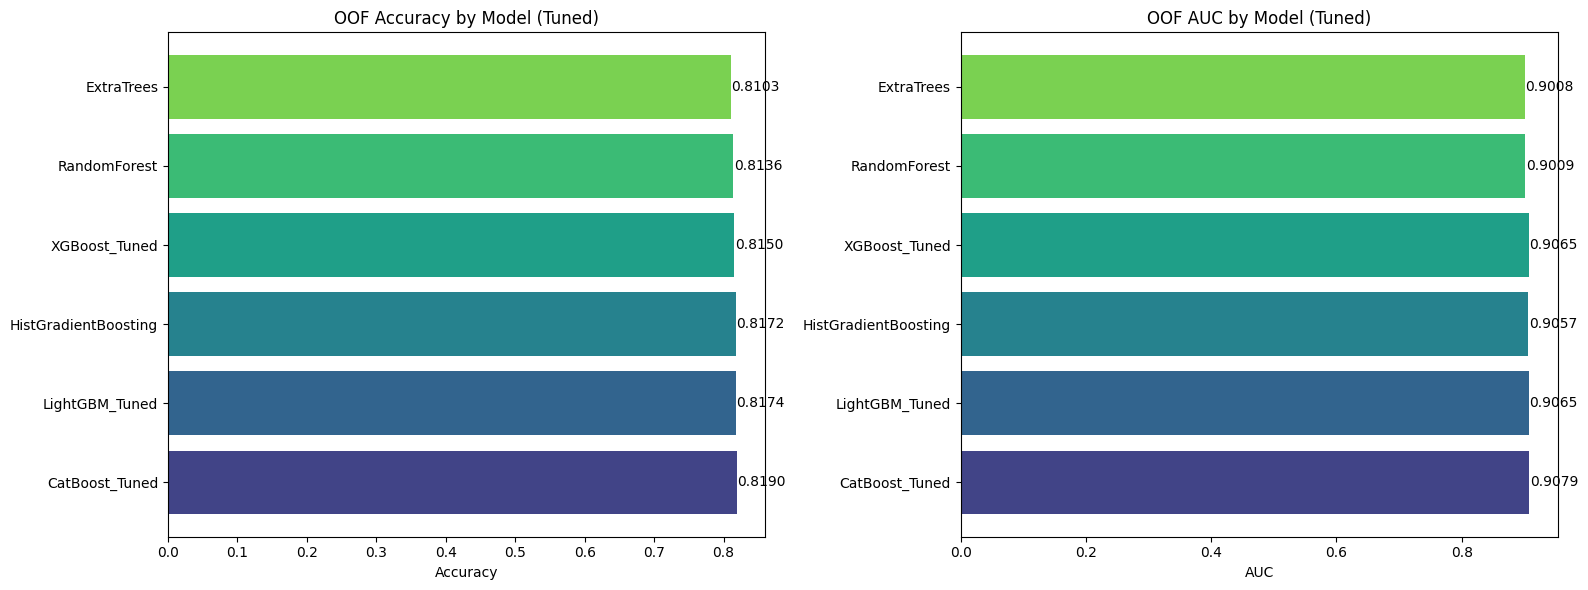

In [18]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy 비교
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))
axes[0].barh(comparison_df['Model'], comparison_df['OOF Accuracy'], color=colors)
axes[0].set_title('OOF Accuracy by Model (Tuned)')
axes[0].set_xlabel('Accuracy')
for i, (acc, model) in enumerate(zip(comparison_df['OOF Accuracy'], comparison_df['Model'])):
    axes[0].text(acc + 0.001, i, f'{acc:.4f}', va='center')

# AUC 비교
axes[1].barh(comparison_df['Model'], comparison_df['OOF AUC'], color=colors)
axes[1].set_title('OOF AUC by Model (Tuned)')
axes[1].set_xlabel('AUC')
for i, (auc, model) in enumerate(zip(comparison_df['OOF AUC'], comparison_df['Model'])):
    axes[1].text(auc + 0.001, i, f'{auc:.4f}', va='center')

plt.tight_layout()
plt.show()

---
# Part 3: 고급 앙상블
---

## 10. Optuna 앙상블 가중치 최적화

In [19]:
# OOF 예측을 사용하여 최적 가중치 찾기
def objective_ensemble(trial):
    # 각 모델의 가중치
    w_lgb = trial.suggest_float('w_lgb', 0, 1)
    w_xgb = trial.suggest_float('w_xgb', 0, 1)
    w_cat = trial.suggest_float('w_cat', 0, 1)
    w_rf = trial.suggest_float('w_rf', 0, 1)
    w_et = trial.suggest_float('w_et', 0, 1)
    w_hgb = trial.suggest_float('w_hgb', 0, 1)
    
    # 가중치 정규화
    total = w_lgb + w_xgb + w_cat + w_rf + w_et + w_hgb
    if total == 0:
        return 0
    
    w_lgb, w_xgb, w_cat, w_rf, w_et, w_hgb = (
        w_lgb/total, w_xgb/total, w_cat/total, w_rf/total, w_et/total, w_hgb/total
    )
    
    # 가중 평균 예측
    oof_ensemble = (
        oof_predictions['LightGBM_Tuned'] * w_lgb +
        oof_predictions['XGBoost_Tuned'] * w_xgb +
        oof_predictions['CatBoost_Tuned'] * w_cat +
        oof_predictions['RandomForest'] * w_rf +
        oof_predictions['ExtraTrees'] * w_et +
        oof_predictions['HistGradientBoosting'] * w_hgb
    )
    
    oof_preds = (oof_ensemble >= 0.5).astype(int)
    return accuracy_score(y_train, oof_preds)

print("="*60)
print("Optuna 앙상블 가중치 최적화")
print("="*60)

study_ensemble = optuna.create_study(direction='maximize', sampler=sampler)
study_ensemble.optimize(objective_ensemble, n_trials=100, show_progress_bar=True)

print(f"\nBest Ensemble Score: {study_ensemble.best_value:.4f}")
print(f"Best Weights: {study_ensemble.best_params}")

Optuna 앙상블 가중치 최적화



  0%|          | 0/100 [00:00<?, ?it/s]


Best trial: 0. Best value: 0.816404:   0%|          | 0/100 [00:00<?, ?it/s]


Best trial: 1. Best value: 0.816519:   1%|          | 1/100 [00:00<00:00, 195.17it/s]


Best trial: 1. Best value: 0.816519:   2%|▏         | 2/100 [00:00<00:00, 280.98it/s]


Best trial: 3. Best value: 0.817669:   3%|▎         | 3/100 [00:00<00:00, 311.32it/s]


Best trial: 3. Best value: 0.817669:   4%|▍         | 4/100 [00:00<00:00, 358.79it/s]


Best trial: 5. Best value: 0.81836:   5%|▌         | 5/100 [00:00<00:00, 348.29it/s] 


Best trial: 5. Best value: 0.81836:   6%|▌         | 6/100 [00:00<00:00, 366.66it/s]


Best trial: 5. Best value: 0.81836:   7%|▋         | 7/100 [00:00<00:00, 361.52it/s]


Best trial: 8. Best value: 0.81859:   8%|▊         | 8/100 [00:00<00:00, 383.20it/s]


Best trial: 8. Best value: 0.81859:   9%|▉         | 9/100 [00:00<00:00, 384.93it/s]


Best trial: 8. Best value: 0.81859:  10%|█         | 10/100 [00:00<00:00, 304.06it/s]


Best trial: 8. Best value: 0.81859:  11%|█         | 11/100 [00:00<00:00, 265.15it/s]


Best trial: 8. Best value: 0.81859:  12%|█▏        | 12/100 [00:00<00:00, 233.34it/s]


Best trial: 8. Best value: 0.81859:  13%|█▎        | 13/100 [00:00<00:00, 219.72it/s]


Best trial: 8. Best value: 0.81859:  14%|█▍        | 14/100 [00:00<00:00, 200.59it/s]


Best trial: 8. Best value: 0.81859:  15%|█▌        | 15/100 [00:00<00:00, 188.46it/s]


Best trial: 8. Best value: 0.81859:  16%|█▌        | 16/100 [00:00<00:00, 181.53it/s]


Best trial: 8. Best value: 0.81859:  17%|█▋        | 17/100 [00:00<00:00, 174.22it/s]


Best trial: 8. Best value: 0.81859:  18%|█▊        | 18/100 [00:00<00:00, 170.00it/s]


Best trial: 8. Best value: 0.81859:  19%|█▉        | 19/100 [00:00<00:00, 179.45it/s]


Best trial: 8. Best value: 0.81859:  19%|█▉        | 19/100 [00:00<00:00, 179.45it/s]


Best trial: 8. Best value: 0.81859:  20%|██        | 20/100 [00:00<00:00, 179.45it/s]


Best trial: 8. Best value: 0.81859:  21%|██        | 21/100 [00:00<00:00, 179.45it/s]


Best trial: 8. Best value: 0.81859:  22%|██▏       | 22/100 [00:00<00:00, 179.45it/s]


Best trial: 8. Best value: 0.81859:  23%|██▎       | 23/100 [00:00<00:00, 179.45it/s]


Best trial: 8. Best value: 0.81859:  24%|██▍       | 24/100 [00:00<00:00, 179.45it/s]


Best trial: 8. Best value: 0.81859:  25%|██▌       | 25/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  26%|██▌       | 26/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  27%|██▋       | 27/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  28%|██▊       | 28/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  29%|██▉       | 29/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  30%|███       | 30/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  31%|███       | 31/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  32%|███▏      | 32/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  33%|███▎      | 33/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  34%|███▍      | 34/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  35%|███▌      | 35/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  36%|███▌      | 36/100 [00:00<00:00, 179.45it/s]


Best trial: 26. Best value: 0.818705:  37%|███▋      | 37/100 [00:00<00:00, 143.48it/s]


Best trial: 26. Best value: 0.818705:  37%|███▋      | 37/100 [00:00<00:00, 143.48it/s]


Best trial: 26. Best value: 0.818705:  38%|███▊      | 38/100 [00:00<00:00, 143.48it/s]


Best trial: 26. Best value: 0.818705:  39%|███▉      | 39/100 [00:00<00:00, 143.48it/s]


Best trial: 26. Best value: 0.818705:  40%|████      | 40/100 [00:00<00:00, 143.48it/s]


Best trial: 26. Best value: 0.818705:  41%|████      | 41/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  42%|████▏     | 42/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  43%|████▎     | 43/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  44%|████▍     | 44/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  45%|████▌     | 45/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  46%|████▌     | 46/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  47%|████▋     | 47/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  48%|████▊     | 48/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  49%|████▉     | 49/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  50%|█████     | 50/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  51%|█████     | 51/100 [00:00<00:00, 143.48it/s]


Best trial: 42. Best value: 0.818935:  52%|█████▏    | 52/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  52%|█████▏    | 52/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  53%|█████▎    | 53/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  54%|█████▍    | 54/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  55%|█████▌    | 55/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  56%|█████▌    | 56/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  57%|█████▋    | 57/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  58%|█████▊    | 58/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  59%|█████▉    | 59/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  60%|██████    | 60/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  61%|██████    | 61/100 [00:00<00:00, 130.30it/s]


Best trial: 42. Best value: 0.818935:  62%|██████▏   | 62/100 [00:00<00:00, 130.30it/s]


Best trial: 63. Best value: 0.819395:  63%|██████▎   | 63/100 [00:00<00:00, 130.30it/s]


Best trial: 63. Best value: 0.819395:  64%|██████▍   | 64/100 [00:00<00:00, 130.30it/s]


Best trial: 63. Best value: 0.819395:  65%|██████▌   | 65/100 [00:00<00:00, 130.30it/s]


Best trial: 63. Best value: 0.819395:  66%|██████▌   | 66/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  66%|██████▌   | 66/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  67%|██████▋   | 67/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  68%|██████▊   | 68/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  69%|██████▉   | 69/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  70%|███████   | 70/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  71%|███████   | 71/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  72%|███████▏  | 72/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  73%|███████▎  | 73/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  74%|███████▍  | 74/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  75%|███████▌  | 75/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  76%|███████▌  | 76/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  77%|███████▋  | 77/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  78%|███████▊  | 78/100 [00:00<00:00, 122.64it/s]


Best trial: 63. Best value: 0.819395:  79%|███████▉  | 79/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  79%|███████▉  | 79/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  80%|████████  | 80/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  81%|████████  | 81/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  82%|████████▏ | 82/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  83%|████████▎ | 83/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  84%|████████▍ | 84/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  85%|████████▌ | 85/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  86%|████████▌ | 86/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  87%|████████▋ | 87/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  88%|████████▊ | 88/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  89%|████████▉ | 89/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  90%|█████████ | 90/100 [00:00<00:00, 114.55it/s]


Best trial: 63. Best value: 0.819395:  91%|█████████ | 91/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395:  91%|█████████ | 91/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395:  92%|█████████▏| 92/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395:  93%|█████████▎| 93/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395:  94%|█████████▍| 94/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395:  95%|█████████▌| 95/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395:  96%|█████████▌| 96/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395:  97%|█████████▋| 97/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395:  98%|█████████▊| 98/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395:  99%|█████████▉| 99/100 [00:00<00:00, 111.68it/s]


Best trial: 63. Best value: 0.819395: 100%|██████████| 100/100 [00:00<00:00, 119.83it/s]


Best Ensemble Score: 0.8194
Best Weights: {'w_lgb': 0.6424576118531187, 'w_xgb': 0.24962513418416749, 'w_cat': 0.19369393889257586, 'w_rf': 0.21006412214786996, 'w_et': 0.47573663534151983, 'w_hgb': 0.7934749247338265}


In [20]:
# 최적 가중치로 앙상블 예측
best_weights = study_ensemble.best_params
total = sum(best_weights.values())
normalized_weights = {k: v/total for k, v in best_weights.items()}

print("정규화된 가중치:")
for k, v in normalized_weights.items():
    print(f"  {k}: {v:.4f}")

# OOF 앙상블 예측
oof_optuna_ensemble = (
    oof_predictions['LightGBM_Tuned'] * normalized_weights['w_lgb'] +
    oof_predictions['XGBoost_Tuned'] * normalized_weights['w_xgb'] +
    oof_predictions['CatBoost_Tuned'] * normalized_weights['w_cat'] +
    oof_predictions['RandomForest'] * normalized_weights['w_rf'] +
    oof_predictions['ExtraTrees'] * normalized_weights['w_et'] +
    oof_predictions['HistGradientBoosting'] * normalized_weights['w_hgb']
)

# Test 앙상블 예측
test_optuna_ensemble = (
    test_predictions['LightGBM_Tuned'] * normalized_weights['w_lgb'] +
    test_predictions['XGBoost_Tuned'] * normalized_weights['w_xgb'] +
    test_predictions['CatBoost_Tuned'] * normalized_weights['w_cat'] +
    test_predictions['RandomForest'] * normalized_weights['w_rf'] +
    test_predictions['ExtraTrees'] * normalized_weights['w_et'] +
    test_predictions['HistGradientBoosting'] * normalized_weights['w_hgb']
)

optuna_acc = accuracy_score(y_train, (oof_optuna_ensemble >= 0.5).astype(int))
optuna_auc = roc_auc_score(y_train, oof_optuna_ensemble)

print(f"\nOptuna Ensemble:")
print(f"  OOF Accuracy: {optuna_acc:.4f}")
print(f"  OOF AUC: {optuna_auc:.4f}")

cv_results['Optuna_Ensemble'] = {'oof_acc': optuna_acc, 'oof_auc': optuna_auc, 'fold_scores': [optuna_acc]}
oof_predictions['Optuna_Ensemble'] = oof_optuna_ensemble
test_predictions['Optuna_Ensemble'] = test_optuna_ensemble

정규화된 가중치:
  w_lgb: 0.2505
  w_xgb: 0.0973
  w_cat: 0.0755
  w_rf: 0.0819
  w_et: 0.1855
  w_hgb: 0.3093

Optuna Ensemble:
  OOF Accuracy: 0.8194
  OOF AUC: 0.9074


## 11. 고급 스태킹 앙상블

In [21]:
print("="*60)
print("고급 Stacking Ensemble (다양한 메타 학습기)")
print("="*60)

# 기본 모델 정의 (튜닝된 파라미터 사용)
base_estimators = [
    ('lgb', lgb.LGBMClassifier(**lgb_best_params)),
    ('xgb', xgb.XGBClassifier(**xgb_best_params)),
    ('cat', CatBoostClassifier(**cat_best_params)),
    ('rf', RandomForestClassifier(**rf_best_params)),
    ('et', ExtraTreesClassifier(**et_best_params)),
    ('hgb', HistGradientBoostingClassifier(**hgb_best_params))
]

# Stacking with LightGBM as meta-learner
stacking_lgb = StackingClassifier(
    estimators=base_estimators,
    final_estimator=lgb.LGBMClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3,
        random_state=RANDOM_STATE, verbosity=-1
    ),
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Cross-validation
stacking_scores = cross_val_score(stacking_lgb, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Stacking (LightGBM Meta) CV Accuracy: {stacking_scores.mean():.4f} (+/- {stacking_scores.std():.4f})")

# 전체 데이터로 학습
stacking_lgb.fit(X_train, y_train)
stacking_test_probs = stacking_lgb.predict_proba(X_test)[:, 1]

cv_results['Stacking_LGB'] = {'cv_mean': stacking_scores.mean(), 'cv_std': stacking_scores.std(), 
                              'oof_acc': stacking_scores.mean(), 'fold_scores': stacking_scores.tolist()}
test_predictions['Stacking_LGB'] = stacking_test_probs

고급 Stacking Ensemble (다양한 메타 학습기)


Stacking (LightGBM Meta) CV Accuracy: 0.8142 (+/- 0.0093)


## 12. Soft Voting (모든 모델)

In [22]:
print("="*60)
print("Soft Voting Ensemble (6 Models)")
print("="*60)

# Soft Voting
voting_all = VotingClassifier(
    estimators=base_estimators,
    voting='soft',
    n_jobs=-1
)

# Cross-validation
voting_scores = cross_val_score(voting_all, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Soft Voting (6 Models) CV Accuracy: {voting_scores.mean():.4f} (+/- {voting_scores.std():.4f})")

# 전체 데이터로 학습
voting_all.fit(X_train, y_train)
voting_test_probs = voting_all.predict_proba(X_test)[:, 1]

cv_results['Voting_All'] = {'cv_mean': voting_scores.mean(), 'cv_std': voting_scores.std(),
                            'oof_acc': voting_scores.mean(), 'fold_scores': voting_scores.tolist()}
test_predictions['Voting_All'] = voting_test_probs

Soft Voting Ensemble (6 Models)


Soft Voting (6 Models) CV Accuracy: 0.8173 (+/- 0.0084)


## 13. 단순 평균 앙상블 (Blending)

In [23]:
print("="*60)
print("Simple Average Ensemble (6 Models)")
print("="*60)

# 단순 평균
oof_avg = (
    oof_predictions['LightGBM_Tuned'] +
    oof_predictions['XGBoost_Tuned'] +
    oof_predictions['CatBoost_Tuned'] +
    oof_predictions['RandomForest'] +
    oof_predictions['ExtraTrees'] +
    oof_predictions['HistGradientBoosting']
) / 6

test_avg = (
    test_predictions['LightGBM_Tuned'] +
    test_predictions['XGBoost_Tuned'] +
    test_predictions['CatBoost_Tuned'] +
    test_predictions['RandomForest'] +
    test_predictions['ExtraTrees'] +
    test_predictions['HistGradientBoosting']
) / 6

avg_acc = accuracy_score(y_train, (oof_avg >= 0.5).astype(int))
avg_auc = roc_auc_score(y_train, oof_avg)

print(f"Simple Average (6 Models):")
print(f"  OOF Accuracy: {avg_acc:.4f}")
print(f"  OOF AUC: {avg_auc:.4f}")

cv_results['Simple_Avg_6'] = {'oof_acc': avg_acc, 'oof_auc': avg_auc, 'fold_scores': [avg_acc]}
test_predictions['Simple_Avg_6'] = test_avg

Simple Average Ensemble (6 Models)
Simple Average (6 Models):
  OOF Accuracy: 0.8173
  OOF AUC: 0.9076


## 13.5 Threshold 최적화

기본 임계값 0.5 대신, OOF 예측을 활용하여 최적의 임계값을 탐색합니다.
- 0.40 ~ 0.60 범위에서 0.01 단위로 탐색
- Accuracy를 기준으로 최적 임계값 선택

In [24]:
print("="*60)
print("Threshold 최적화")
print("="*60)

# 최적화할 모델 목록 (OOF 예측이 있는 모델)
models_for_threshold = ['LightGBM_Tuned', 'XGBoost_Tuned', 'CatBoost_Tuned', 
                        'RandomForest', 'ExtraTrees', 'HistGradientBoosting',
                        'Optuna_Ensemble', 'Simple_Avg_6']

# Threshold 탐색 범위
thresholds = np.arange(0.40, 0.61, 0.01)

# 결과 저장
threshold_results = {}

for model_name in models_for_threshold:
    if model_name not in oof_predictions:
        continue
    
    oof_probs = oof_predictions[model_name]
    best_threshold = 0.5
    best_acc = 0
    
    # 각 임계값에 대해 정확도 계산
    threshold_accs = []
    for thresh in thresholds:
        preds = (oof_probs >= thresh).astype(int)
        acc = accuracy_score(y_train, preds)
        threshold_accs.append(acc)
        
        if acc > best_acc:
            best_acc = acc
            best_threshold = thresh
    
    threshold_results[model_name] = {
        'best_threshold': best_threshold,
        'best_acc': best_acc,
        'default_acc': accuracy_score(y_train, (oof_probs >= 0.5).astype(int)),
        'improvement': best_acc - accuracy_score(y_train, (oof_probs >= 0.5).astype(int))
    }
    
    print(f"\n{model_name}:")
    print(f"  Default (0.5) Accuracy: {threshold_results[model_name]['default_acc']:.4f}")
    print(f"  Best Threshold: {best_threshold:.2f}")
    print(f"  Best Accuracy: {best_acc:.4f}")
    print(f"  Improvement: {threshold_results[model_name]['improvement']:+.4f}")

Threshold 최적화

LightGBM_Tuned:
  Default (0.5) Accuracy: 0.8174
  Best Threshold: 0.49
  Best Accuracy: 0.8180
  Improvement: +0.0006

XGBoost_Tuned:
  Default (0.5) Accuracy: 0.8150
  Best Threshold: 0.51
  Best Accuracy: 0.8155
  Improvement: +0.0005

CatBoost_Tuned:
  Default (0.5) Accuracy: 0.8190
  Best Threshold: 0.50
  Best Accuracy: 0.8190
  Improvement: +0.0000

RandomForest:
  Default (0.5) Accuracy: 0.8136
  Best Threshold: 0.50
  Best Accuracy: 0.8136
  Improvement: +0.0000

ExtraTrees:
  Default (0.5) Accuracy: 0.8103
  Best Threshold: 0.50
  Best Accuracy: 0.8103
  Improvement: +0.0000

HistGradientBoosting:
  Default (0.5) Accuracy: 0.8172
  Best Threshold: 0.48
  Best Accuracy: 0.8178
  Improvement: +0.0006

Optuna_Ensemble:
  Default (0.5) Accuracy: 0.8194
  Best Threshold: 0.50
  Best Accuracy: 0.8194
  Improvement: +0.0000


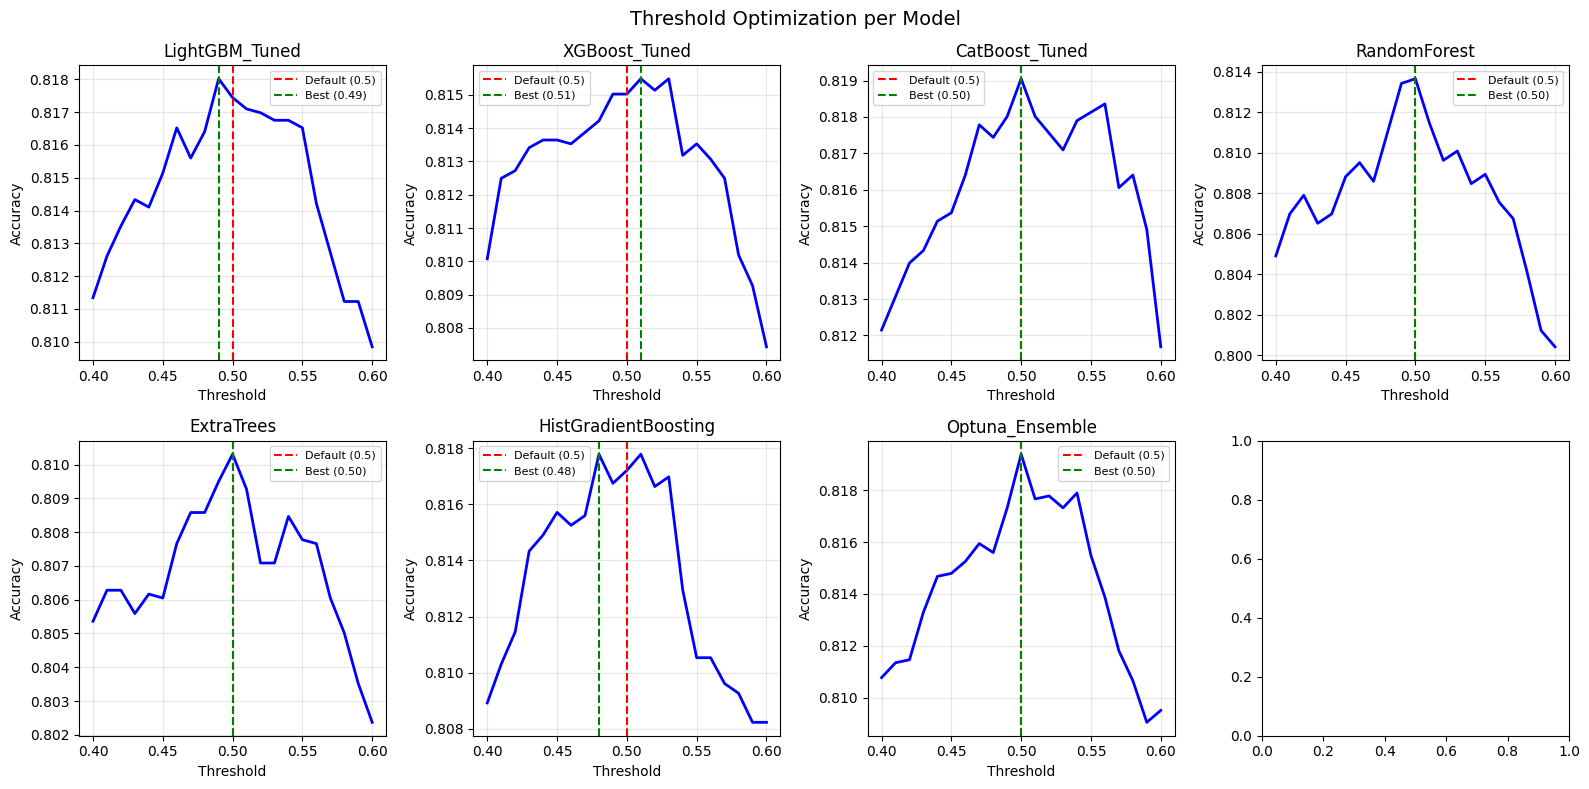


Threshold 최적화 요약
               Model  Default_Acc  Best_Threshold  Best_Acc  Improvement
     Optuna_Ensemble     0.819395            0.50  0.819395     0.000000
      CatBoost_Tuned     0.819050            0.50  0.819050     0.000000
      LightGBM_Tuned     0.817439            0.49  0.818014     0.000575
HistGradientBoosting     0.817209            0.48  0.817784     0.000575
       XGBoost_Tuned     0.815024            0.51  0.815484     0.000460
        RandomForest     0.813643            0.50  0.813643     0.000000
          ExtraTrees     0.810307            0.50  0.810307     0.000000


In [25]:
# Threshold 최적화 결과 시각화
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, model_name in enumerate(models_for_threshold):
    if model_name not in oof_predictions or idx >= len(axes):
        continue
    
    oof_probs = oof_predictions[model_name]
    accs = [accuracy_score(y_train, (oof_probs >= t).astype(int)) for t in thresholds]
    
    ax = axes[idx]
    ax.plot(thresholds, accs, 'b-', linewidth=2)
    ax.axvline(x=0.5, color='r', linestyle='--', label='Default (0.5)')
    ax.axvline(x=threshold_results[model_name]['best_threshold'], 
               color='g', linestyle='--', label=f"Best ({threshold_results[model_name]['best_threshold']:.2f})")
    ax.set_title(f"{model_name}")
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Accuracy')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Threshold Optimization per Model', fontsize=14)
plt.tight_layout()
plt.show()

# 개선된 모델 요약
print("\n" + "="*60)
print("Threshold 최적화 요약")
print("="*60)
threshold_summary = pd.DataFrame([
    {'Model': k, 'Default_Acc': v['default_acc'], 'Best_Threshold': v['best_threshold'],
     'Best_Acc': v['best_acc'], 'Improvement': v['improvement']}
    for k, v in threshold_results.items()
]).sort_values('Best_Acc', ascending=False)
print(threshold_summary.to_string(index=False))

In [26]:
# 최적화된 임계값으로 제출 파일 생성
print("="*60)
print("Threshold 최적화된 제출 파일 생성")
print("="*60)

for model_name in models_for_threshold:
    if model_name not in test_predictions or model_name not in threshold_results:
        continue
    
    best_thresh = threshold_results[model_name]['best_threshold']
    
    # 기본 임계값(0.5)과 다른 경우만 새 파일 생성
    if best_thresh != 0.5:
        test_probs = test_predictions[model_name]
        optimized_preds = (test_probs >= best_thresh).astype(bool)
        
        submission = pd.DataFrame({
            'PassengerId': test_ids,
            'Transported': optimized_preds
        })
        
        filename = f"submission_{model_name.lower()}_thresh{best_thresh:.2f}.csv"
        submission.to_csv(f'../submissions/{filename}', index=False)
        print(f"Saved: {filename} (Threshold: {best_thresh:.2f}, OOF Acc: {threshold_results[model_name]['best_acc']:.4f})")

print("\nThreshold 최적화된 제출 파일 생성 완료!")

Threshold 최적화된 제출 파일 생성
Saved: submission_lightgbm_tuned_thresh0.49.csv (Threshold: 0.49, OOF Acc: 0.8180)
Saved: submission_xgboost_tuned_thresh0.51.csv (Threshold: 0.51, OOF Acc: 0.8155)
Saved: submission_catboost_tuned_thresh0.50.csv (Threshold: 0.50, OOF Acc: 0.8190)
Saved: submission_randomforest_thresh0.50.csv (Threshold: 0.50, OOF Acc: 0.8136)
Saved: submission_extratrees_thresh0.50.csv (Threshold: 0.50, OOF Acc: 0.8103)
Saved: submission_histgradientboosting_thresh0.48.csv (Threshold: 0.48, OOF Acc: 0.8178)
Saved: submission_optuna_ensemble_thresh0.50.csv (Threshold: 0.50, OOF Acc: 0.8194)

Threshold 최적화된 제출 파일 생성 완료!


## 14. 최종 성능 비교

In [27]:
# 최종 결과 정리
final_models = [
    'LightGBM_Tuned', 'XGBoost_Tuned', 'CatBoost_Tuned',
    'RandomForest', 'ExtraTrees', 'HistGradientBoosting',
    'Optuna_Ensemble', 'Stacking_LGB', 'Voting_All', 'Simple_Avg_6'
]

final_results = pd.DataFrame({
    'Model': final_models,
    'Score': [cv_results[m]['oof_acc'] if 'oof_acc' in cv_results[m] else cv_results[m]['cv_mean'] 
              for m in final_models]
}).sort_values('Score', ascending=False)

print("\n" + "="*70)
print("최종 모델 성능 비교 (높은 순)")
print("="*70)
print(final_results.to_string(index=False))


최종 모델 성능 비교 (높은 순)
               Model    Score
     Optuna_Ensemble 0.819395
      CatBoost_Tuned 0.819050
      LightGBM_Tuned 0.817439
          Voting_All 0.817324
        Simple_Avg_6 0.817324
HistGradientBoosting 0.817209
       XGBoost_Tuned 0.815024
        Stacking_LGB 0.814218
        RandomForest 0.813643
          ExtraTrees 0.810307


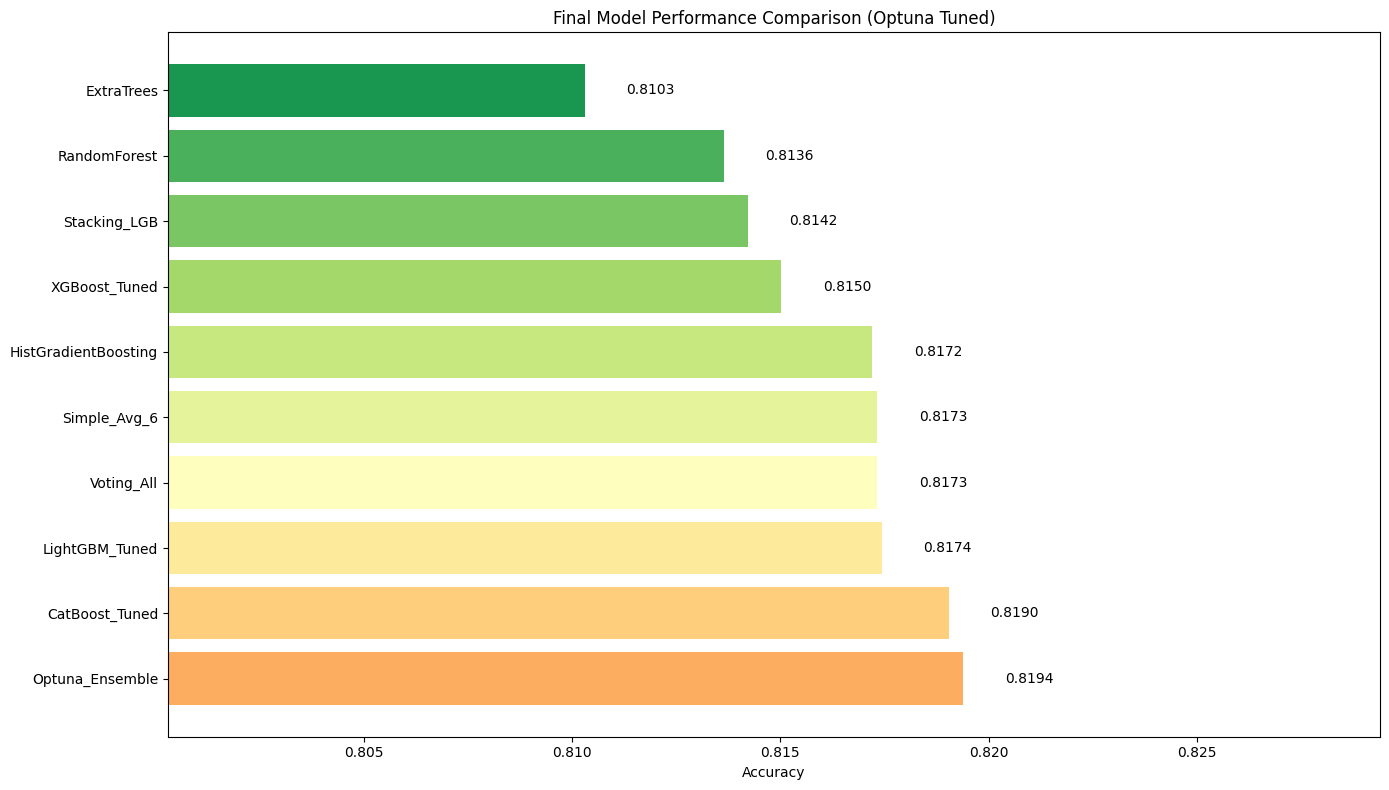

In [28]:
# 최종 시각화
plt.figure(figsize=(14, 8))
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(final_results)))
bars = plt.barh(final_results['Model'], final_results['Score'], color=colors)
plt.xlabel('Accuracy')
plt.title('Final Model Performance Comparison (Optuna Tuned)')
plt.xlim([min(final_results['Score']) - 0.01, max(final_results['Score']) + 0.01])

for bar, score in zip(bars, final_results['Score']):
    plt.text(score + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 15. 제출 파일 생성

In [29]:
# 최고 성능 모델 확인
best_model = final_results.iloc[0]['Model']
print(f"Best Model: {best_model}")

# 각 모델별 제출 파일 생성
submissions = {}
for model_name in final_models:
    if model_name in test_predictions:
        submissions[model_name.lower()] = (test_predictions[model_name] >= 0.5).astype(bool)

Best Model: Optuna_Ensemble


In [30]:
# 모든 제출 파일 생성
for name, preds in submissions.items():
    submission = pd.DataFrame({
        'PassengerId': test_ids,
        'Transported': preds
    })
    submission.to_csv(f'../submissions/submission_{name}.csv', index=False)
    print(f"Saved: submission_{name}.csv")

print("\n모든 제출 파일 생성 완료!")

Saved: submission_lightgbm_tuned.csv
Saved: submission_xgboost_tuned.csv
Saved: submission_catboost_tuned.csv
Saved: submission_randomforest.csv
Saved: submission_extratrees.csv
Saved: submission_histgradientboosting.csv
Saved: submission_optuna_ensemble.csv
Saved: submission_stacking_lgb.csv
Saved: submission_voting_all.csv
Saved: submission_simple_avg_6.csv

모든 제출 파일 생성 완료!


In [31]:
# Best 제출 파일 확인
best_submission_name = best_model.lower()
best_submission = pd.read_csv(f'../submissions/submission_{best_submission_name}.csv')
print(f"Best Submission ({best_model}):")
print(best_submission.head(10))
print(f"\nShape: {best_submission.shape}")
print(f"\nTransported 분포:")
print(best_submission['Transported'].value_counts())

Best Submission (Optuna_Ensemble):
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
5     0027_01         True
6     0029_01         True
7     0032_01         True
8     0032_02         True
9     0033_01         True

Shape: (4277, 2)

Transported 분포:
Transported
True     2198
False    2079
Name: count, dtype: int64


## 16. 모델 저장

In [32]:
# Optuna 스터디 결과 저장
optuna_results = {
    'lgb_best_params': lgb_best_params,
    'xgb_best_params': xgb_best_params,
    'cat_best_params': cat_best_params,
    'rf_best_params': rf_best_params,
    'et_best_params': et_best_params,
    'hgb_best_params': hgb_best_params,
    'ensemble_weights': normalized_weights
}

with open('../models/optuna_best_params.pkl', 'wb') as f:
    pickle.dump(optuna_results, f)

# 앙상블 모델 저장
with open('../models/stacking_lgb_meta.pkl', 'wb') as f:
    pickle.dump(stacking_lgb, f)

with open('../models/voting_all.pkl', 'wb') as f:
    pickle.dump(voting_all, f)

print("모델 저장 완료!")
print("\n저장된 파일:")
print("- models/optuna_best_params.pkl")
print("- models/stacking_lgb_meta.pkl")
print("- models/voting_all.pkl")

모델 저장 완료!

저장된 파일:
- models/optuna_best_params.pkl
- models/stacking_lgb_meta.pkl
- models/voting_all.pkl


## 17. 결론

### 적용된 개선 사항
1. **Optuna 하이퍼파라미터 튜닝**: LightGBM, XGBoost, CatBoost, RandomForest, ExtraTrees, HistGradientBoosting
2. **추가 모델**: RandomForest, ExtraTrees, HistGradientBoosting
3. **다양한 앙상블**:
   - Optuna 가중치 최적화 앙상블
   - 6개 모델 Stacking (LightGBM 메타 학습기)
   - 6개 모델 Soft Voting
   - 6개 모델 단순 평균

### 추천 제출 파일
1. 가장 높은 점수를 기록한 모델의 submission 파일
2. `submission_optuna_ensemble.csv` - Optuna 가중치 최적화 앙상블
3. `submission_stacking_lgb.csv` - 고급 스태킹 앙상블

In [33]:
print("="*60)
print("모델링 완료!")
print("="*60)
print(f"\nBest Model: {best_model}")
print(f"Best Score: {final_results.iloc[0]['Score']:.4f}")
print(f"\n추천 제출: submission_{best_submission_name}.csv")

모델링 완료!

Best Model: Optuna_Ensemble
Best Score: 0.8194

추천 제출: submission_optuna_ensemble.csv
